# Import

**Goal: Predict bike renting using Time Series techniques.**


In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score



In [ ]:
# RANDOM_STATE = 31415926
### Plotting
plt.rcParams["figure.figsize"] = (12, 8)

# sns.set(style='whitegrid', palette="bright")
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14
# plt.style.use('seaborn')

# 1. EDA and data engineering

In [ ]:
# Connecting to google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/Time_series/hour.csv'  

# the link to my drive: https://drive.google.com/drive/folders/10YqEQI-RgiJF37RHIfqI_fqYHKArAqDA?usp=share_link

In [ ]:
data = pd.read_csv(DATA_PATH, sep=',') 

In [ ]:
data.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [ ]:
data.tail()

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
17374           1           2  0.26  0.2576  0.60     0.1642      11   
17375           1           2  0.26  0.2576  0.60     0.1642       8   
17376           1           1  0.26  0.2576  0.60     0.1642       7   
17377           1           1  0.26  0.2727  0.56     0.1343      13   
17378           1           1  0.26  0.2727  0.65     0.1343      12   

       registered  cnt  
17374         108  119  
17375          81   89  
17376          83   90  
17377          48   61  
17378          37   49

In [ ]:
stats = data.describe()
stats.loc['var'] = data.var().tolist()
stats.loc['skew'] = data.skew().tolist()
stats.loc['kurt'] = data.kurtosis().tolist()
stats

<ipython-input-10-c7b55814eb60>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['var'] = data.var().tolist()
<ipython-input-10-c7b55814eb60>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['skew'] = data.skew().tolist()
<ipython-input-10-c7b55814eb60>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['kurt'] = data.kurtosis().tolist()


instant        season            yr          mnth            hr  \
count  1.737900e+04  17379.000000  17379.000000  17379.000000  17379.000000   
mean   8.690000e+03      2.501640      0.502561      6.537775     11.546752   
std    5.017029e+03      1.106918      0.500008      3.438776      6.914405   
min    1.000000e+00      1.000000      0.000000      1.000000      0.000000   
25%    4.345500e+03      2.000000      0.000000      4.000000      6.000000   
50%    8.690000e+03      3.000000      1.000000      7.000000     12.000000   
75%    1.303450e+04      3.000000      1.000000     10.000000     18.000000   
max    1.737900e+04      4.000000      1.000000     12.000000     23.000000   
var    2.517058e+07      1.225268      0.250008     11.825178     47.808998   
skew   0.000000e+00     -0.005416     -0.010243     -0.009253     -0.010680   
kurt  -1.200000e+00     -1.334251     -2.000125     -1.201878     -1.198021   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   
var        0.027944      4.023119      0.216626      0.408777      0.037078   
skew       5.638538     -0.002998     -0.785258      1.228047     -0.006021   
kurt      29.796540     -1.255997     -1.383529      0.350151     -0.941844   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   
var        0.029532      0.037222      0.014967   2430.986021  22909.027999   
skew      -0.090429     -0.111287      0.574905      2.499237      1.557904   
kurt      -0.845412     -0.826117      0.590820      7.571002      2.750018   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000  
var    32901.461104  
skew       1.277412  
kurt       1.417203

In [ ]:
data.corr()

instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164 -0.004775  0.014723   
season      0.404046  1.000000 -0.010742  0.830386 -0.006117 -0.009585   
yr          0.866014 -0.010742  1.000000 -0.010473 -0.003867  0.006692   
mnth        0.489164  0.830386 -0.010473  1.000000 -0.005772  0.018430   
hr         -0.004775 -0.006117 -0.003867 -0.005772  1.000000  0.000479   
holiday     0.014723 -0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357 -0.002335 -0.004485  0.010400 -0.003498 -0.102088   
workingday -0.003416  0.013743 -0.002196 -0.003477  0.002285 -0.252471   
weathersit -0.014198 -0.014524 -0.019157  0.005400 -0.020203 -0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603 -0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750 -0.030973   
hum         0.009577  0.150625 -0.083546  0.164411 -0.276498 -0.010588   
windspeed  -0.074505 -0.149773 -0.008740 -0.135386  0.137252  0.003988   
casual      0.158295  0.120206  0.142779  0.068457  0.301202  0.031564   
registered  0.282046  0.174226  0.253684  0.122273  0.374141 -0.047345   
cnt         0.278379  0.178056  0.250495  0.120638  0.394071 -0.030927   

             weekday  workingday  weathersit      temp     atemp       hum  \
instant     0.001357   -0.003416   -0.014198  0.136178  0.137615  0.009577   
season     -0.002335    0.013743   -0.014524  0.312025  0.319380  0.150625   
yr         -0.004485   -0.002196   -0.019157  0.040913  0.039222 -0.083546   
mnth        0.010400   -0.003477    0.005400  0.201691  0.208096  0.164411   
hr         -0.003498    0.002285   -0.020203  0.137603  0.133750 -0.276498   
holiday    -0.102088   -0.252471   -0.017036 -0.027340 -0.030973 -0.010588   
weekday     1.000000    0.035955    0.003311 -0.001795 -0.008821 -0.037158   
workingday  0.035955    1.000000    0.044672  0.055390  0.054667  0.015688   
weathersit  0.003311    0.044672    1.000000 -0.102640 -0.105563  0.418130   
temp       -0.001795    0.055390   -0.102640  1.000000  0.987672 -0.069881   
atemp      -0.008821    0.054667   -0.105563  0.987672  1.000000 -0.051918   
hum        -0.037158    0.015688    0.418130 -0.069881 -0.051918  1.000000   
windspeed   0.011502   -0.011830    0.026226 -0.023125 -0.062336 -0.290105   
casual      0.032721   -0.300942   -0.152628  0.459616  0.454080 -0.347028   
registered  0.021578    0.134326   -0.120966  0.335361  0.332559 -0.273933   
cnt         0.026900    0.030284   -0.142426  0.404772  0.400929 -0.322911   

            windspeed    casual  registered       cnt  
instant     -0.074505  0.158295    0.282046  0.278379  
season      -0.149773  0.120206    0.174226  0.178056  
yr          -0.008740  0.142779    0.253684  0.250495  
mnth        -0.135386  0.068457    0.122273  0.120638  
hr           0.137252  0.301202    0.374141  0.394071  
holiday      0.003988  0.031564   -0.047345 -0.030927  
weekday      0.011502  0.032721    0.021578  0.026900  
workingday  -0.011830 -0.300942    0.134326  0.030284  
weathersit   0.026226 -0.152628   -0.120966 -0.142426  
temp        -0.023125  0.459616    0.335361  0.404772  
atemp       -0.062336  0.454080    0.332559  0.400929  
hum         -0.290105 -0.347028   -0.273933 -0.322911  
windspeed    1.000000  0.090287    0.082321  0.093234  
casual       0.090287  1.000000    0.506618  0.694564  
registered   0.082321  0.506618    1.000000  0.972151  
cnt          0.093234  0.694564    0.972151  1.000000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We do not have missing value

In [ ]:
data.shape

(17379, 17)

In [ ]:
data.nunique()


instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
dtype: int64

In [ ]:
#Rename the columns
data.rename(columns={'dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [ ]:
# Drop the 'instant' column
data.drop('instant', axis=1, inplace=True)

In [ ]:
# Drop the 'casual' column
#data.drop('casual', axis=1, inplace=True)

In [ ]:
# Drop the 'registered' column
#data.drop('registered', axis=1, inplace=True)

In [ ]:
# # Convert the 'dteday' column to a datetime object
data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
data.season.value_counts()
# 1:'spring',2:'summer',3:'fall',4:'winter'

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [ ]:
data['weather_condition'].value_counts()
# 1:'Clear',2:'Mist',3:'Light Snow',4:'Heavy Rain'

1    11413
2     4544
3     1419
4        3
Name: weather_condition, dtype: int64

In [ ]:
data['workingday'].value_counts()
# 1:'working_day',0:'Holiday'

1    11865
0     5514
Name: workingday, dtype: int64

In [ ]:
data['month'].value_counts()
# 1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'

5     1488
7     1488
12    1483
8     1475
3     1473
10    1451
6     1440
4     1437
9     1437
11    1437
1     1429
2     1341
Name: month, dtype: int64

In [ ]:
data['weekday'].value_counts()
# 0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'

6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64

In [ ]:
data['year'].value_counts()
# 0:"2011",1:"2012"

1    8734
0    8645
Name: year, dtype: int64

In [ ]:
data.head()

datetime  season  year  month  hr  holiday  weekday  workingday  \
0 2011-01-01       1     0      1   0        0        6           0   
1 2011-01-01       1     0      1   1        0        6           0   
2 2011-01-01       1     0      1   2        0        6           0   
3 2011-01-01       1     0      1   3        0        6           0   
4 2011-01-01       1     0      1   4        0        6           0   

   weather_condition  temp   atemp  humidity  windspeed  casual  registered  \
0                  1  0.24  0.2879      0.81        0.0       3          13   
1                  1  0.22  0.2727      0.80        0.0       8          32   
2                  1  0.22  0.2727      0.80        0.0       5          27   
3                  1  0.24  0.2879      0.75        0.0       3          10   
4                  1  0.24  0.2879      0.75        0.0       0           1   

   total_count  
0           16  
1           40  
2           32  
3           13  
4            1

In [ ]:
# Dividing column into continuous and categorical column
cont_col =[ 'temp','atemp','humidity','windspeed', 'casual', 'registered']

cat_col =['season','year','month','weekday','workingday','weather_condition']

target = ['total_count']

len(cont_col) + len(cat_col) + len(target)


13

Plotting the features

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


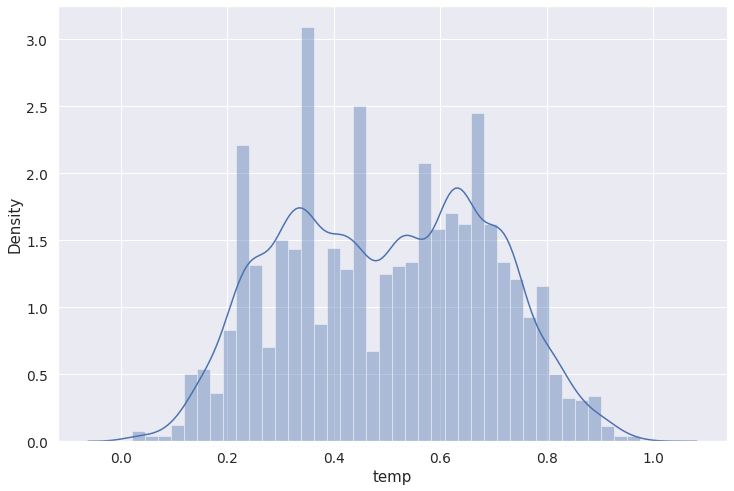

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


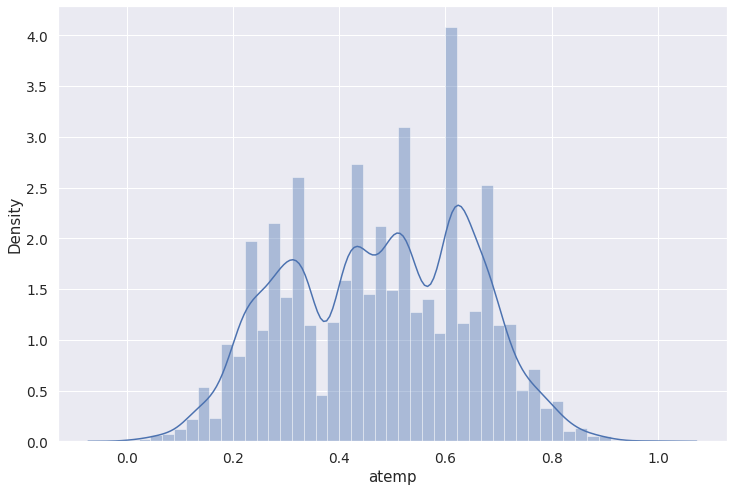

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


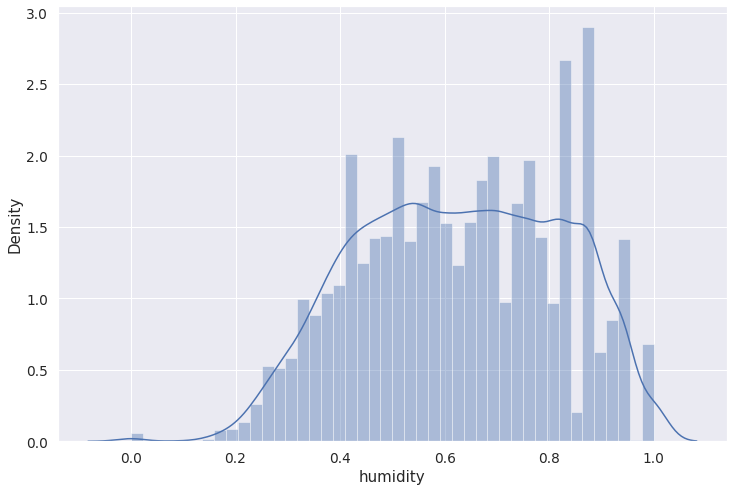

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


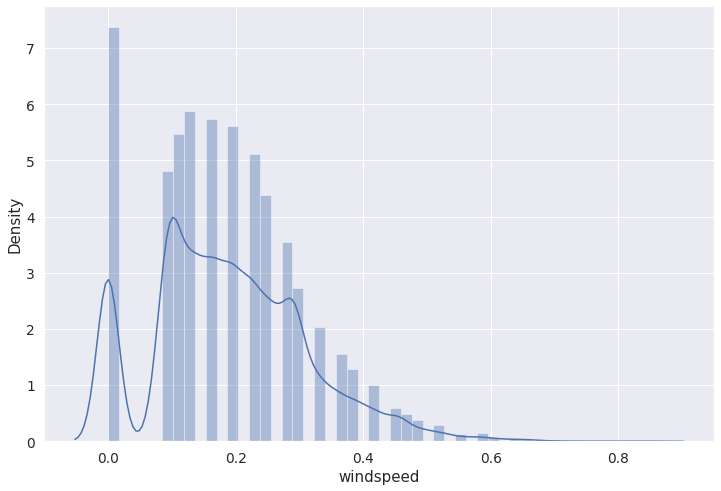

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


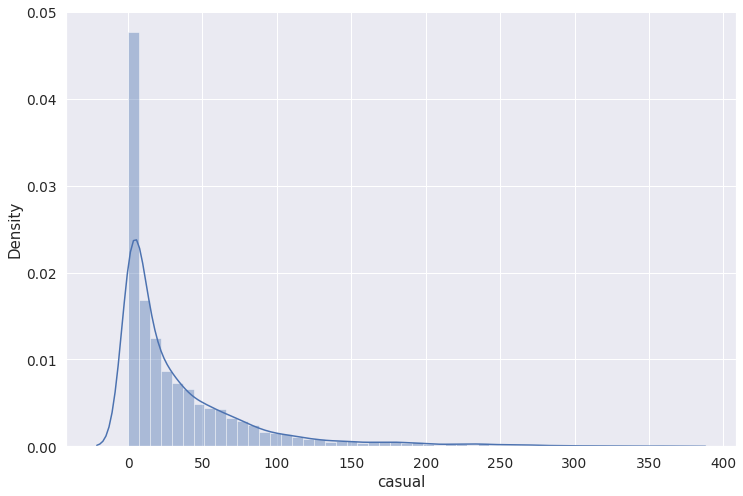

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


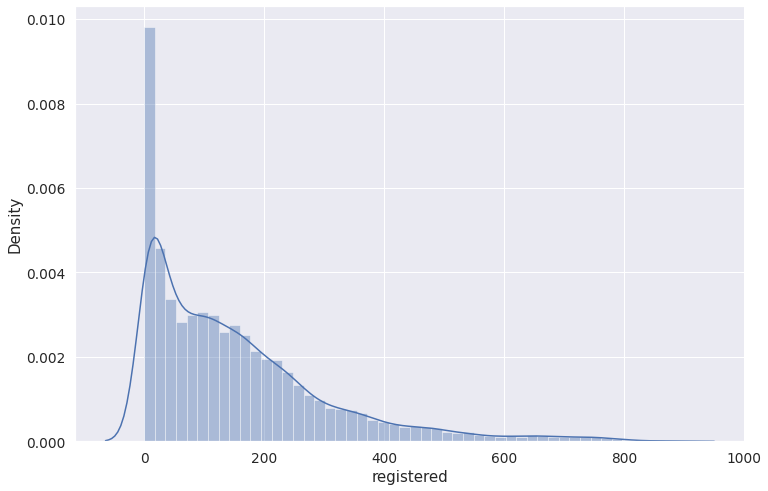

In [ ]:
for i in cont_col:
    sns.distplot(data[i])
    plt.show()

temp and atemp have similar kind of distribution, some features are showing near by normal distribution while e.g windspeed and humidity are skewed

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


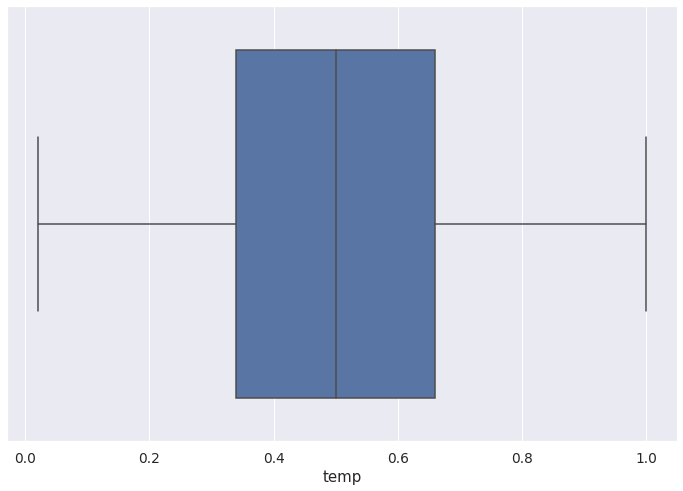

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


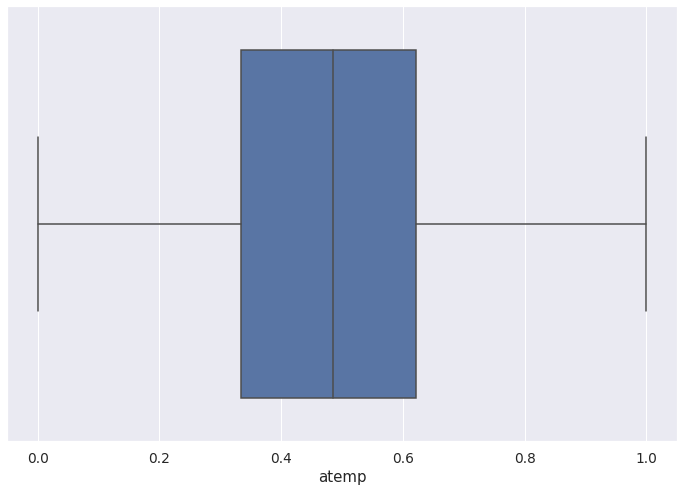

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


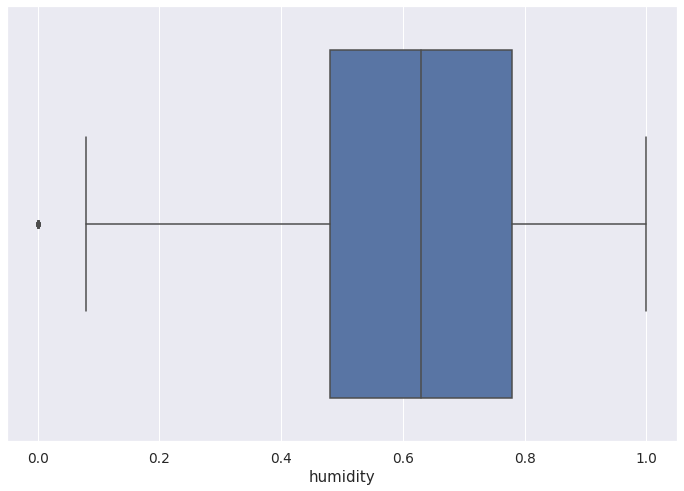

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


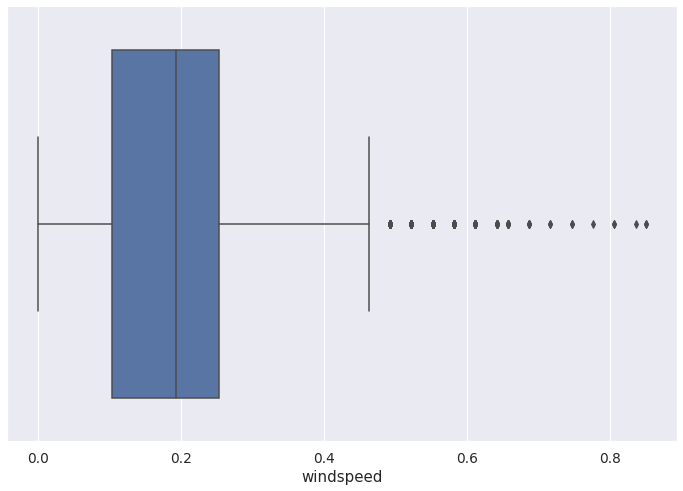

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


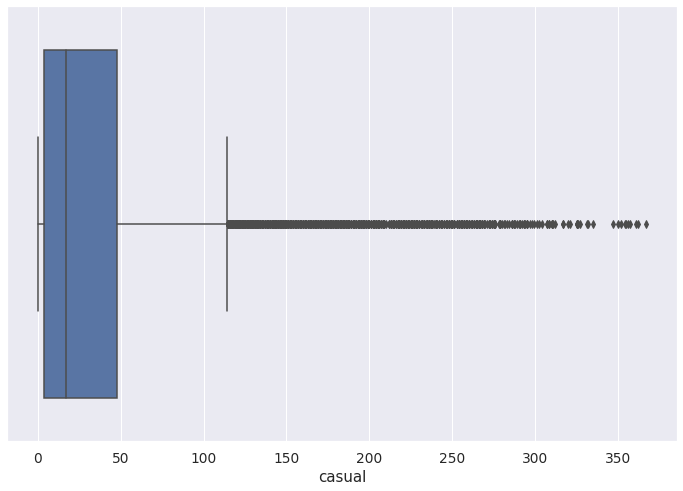

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


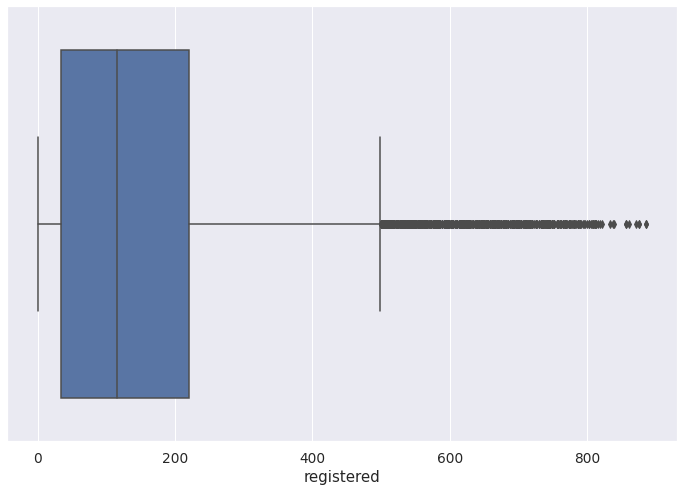

In [ ]:
for i in cont_col:
    sns.boxplot(data[i])
    plt.show()

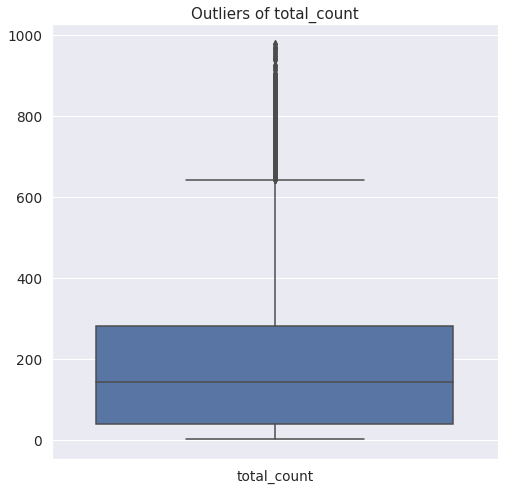

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
#Boxplot for cnt
sns.boxplot(data=data[['total_count']])
ax.set_title('Outliers of total_count')
plt.show()

In [ ]:
!pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 14.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29898 sha256=4a4d72a9011f1a1a2fa760887e37d360e3be0ab9f977b28a41d5b05cd749a21b
  Stored in directory: /root/.cache/pip/wheels/f9/fc/6a/b0406b906bce293abe23c3b6da5a72637d2d04146ef1125a0b
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=ce70d08fcb013ecbbfd0944891d26c396dd1df2706e4615e5eae356328fc6b6c
  Stored in directory: /root/.cache/pip/wheels/88/c4/be/e232c750d9bc360abf9a5e2cafe0d3e08e3605d2801bb11684
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import KNN

#create dataframe for outliers
outliers=pd.DataFrame(data,columns=['humidity', 'windspeed'])
 #Cnames for outliers                     
cnames=['humidity', 'windspeed']       
                      
for i in cnames:
    q75,q25=np.percentile(outliers.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    outliers.loc[outliers.loc[:,i]<min,:i]=np.nan  #Replace with NA
    outliers.loc[outliers.loc[:,i]>max,:i]=np.nan  #Replace with NA
#Imputating the outliers by mean Imputation
outliers['humidity']=outliers['humidity'].fillna(outliers['humidity'].mean())
outliers['windspeed']=outliers['windspeed'].fillna(outliers['windspeed'].mean())
# outliers['total_count']=outliers['total_count'].fillna(outliers['total_count'].mean())

In [ ]:
#Replacing the imputated humidity
data['humidity']=data['humidity'].replace(outliers['humidity'])
#Replacing the imputated windspeed
data['windspeed']=data['windspeed'].replace(outliers['windspeed'])

# I decided to not impute 'total_count', I prefer to work with original data
# data['total_count']=data['total_count'].replace(outliers['total_count'])


In [ ]:
data.head()

datetime  season  year  month  hr  holiday  weekday  workingday  \
0 2011-01-01       1     0      1   0        0        6           0   
1 2011-01-01       1     0      1   1        0        6           0   
2 2011-01-01       1     0      1   2        0        6           0   
3 2011-01-01       1     0      1   3        0        6           0   
4 2011-01-01       1     0      1   4        0        6           0   

   weather_condition  temp   atemp  humidity  windspeed  casual  registered  \
0                  1  0.24  0.2879      0.81        0.0       3          13   
1                  1  0.22  0.2727      0.80        0.0       8          32   
2                  1  0.22  0.2727      0.80        0.0       5          27   
3                  1  0.24  0.2879      0.75        0.0       3          10   
4                  1  0.24  0.2879      0.75        0.0       0           1   

   total_count  
0           16  
1           40  
2           32  
3           13  
4            1

In [ ]:
data.describe()

season          year         month            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday  weather_condition          temp  \
count  17379.000000  17379.000000       17379.000000  17379.000000   
mean       3.003683      0.682721           1.425283      0.496987   
std        2.005771      0.465431           0.639357      0.192556   
min        0.000000      0.000000           1.000000      0.020000   
25%        1.000000      0.000000           1.000000      0.340000   
50%        3.000000      1.000000           1.000000      0.500000   
75%        5.000000      1.000000           2.000000      0.660000   
max        6.000000      1.000000           4.000000      1.000000   

              atemp      humidity     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.625147      0.190098     35.676218    153.786869   
std        0.171850      0.187261      0.122340     49.305030    151.357286   
min        0.000000      0.080000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      0.970000      0.850700    367.000000    886.000000   

        total_count  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [ ]:
data.isna().sum()

datetime             0
season               0
year                 0
month                0
hr                   0
holiday              0
weekday              0
workingday           0
weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
total_count          0
dtype: int64

In [ ]:
stats2 = data.describe()
stats2.loc['var'] = data.var().tolist()
stats2.loc['skew'] = data.skew().tolist()
stats2.loc['kurt'] = data.kurtosis().tolist()
stats2

<ipython-input-38-c6a21a61c4fd>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['var'] = data.var().tolist()
<ipython-input-38-c6a21a61c4fd>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['skew'] = data.skew().tolist()
<ipython-input-38-c6a21a61c4fd>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['kurt'] = data.kurtosis().tolist()


season          year         month            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   
var        1.225268      0.250008     11.825178     47.808998      0.027944   
skew      -0.005416     -0.010243     -0.009253     -0.010680      5.638538   
kurt      -1.334251     -2.000125     -1.201878     -1.198021     29.796540   

            weekday    workingday  weather_condition          temp  \
count  17379.000000  17379.000000       17379.000000  17379.000000   
mean       3.003683      0.682721           1.425283      0.496987   
std        2.005771      0.465431           0.639357      0.192556   
min        0.000000      0.000000           1.000000      0.020000   
25%        1.000000      0.000000           1.000000      0.340000   
50%        3.000000      1.000000           1.000000      0.500000   
75%        5.000000      1.000000           2.000000      0.660000   
max        6.000000      1.000000           4.000000      1.000000   
var        4.023119      0.216626           0.408777      0.037078   
skew      -0.002998     -0.785258           1.228047     -0.006021   
kurt      -1.255997     -1.383529           0.350151     -0.941844   

              atemp      humidity     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.625147      0.190098     35.676218    153.786869   
std        0.171850      0.187261      0.122340     49.305030    151.357286   
min        0.000000      0.080000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      0.970000      0.850700    367.000000    886.000000   
var        0.029532      0.035067      0.014967   2430.986021  22909.027999   
skew      -0.090429     -0.149962      0.574905      2.499237      1.557904   
kurt      -0.845412     -0.949072      0.590820      7.571002      2.750018   

        total_count  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000  
var    32901.461104  
skew       1.277412  
kurt       1.417203

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


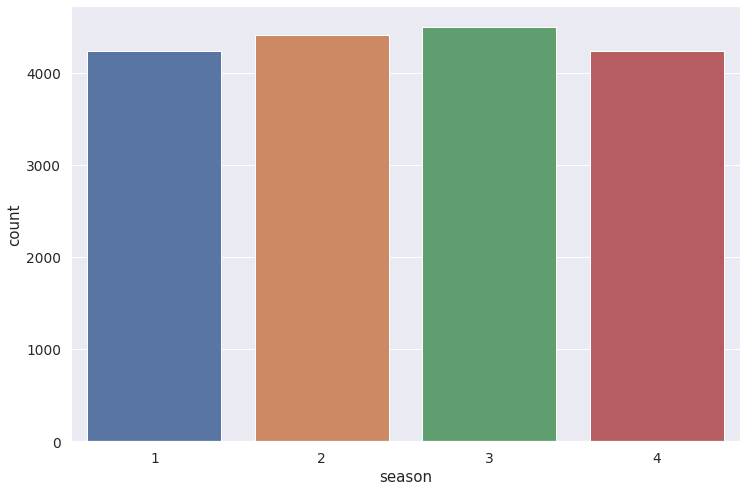

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


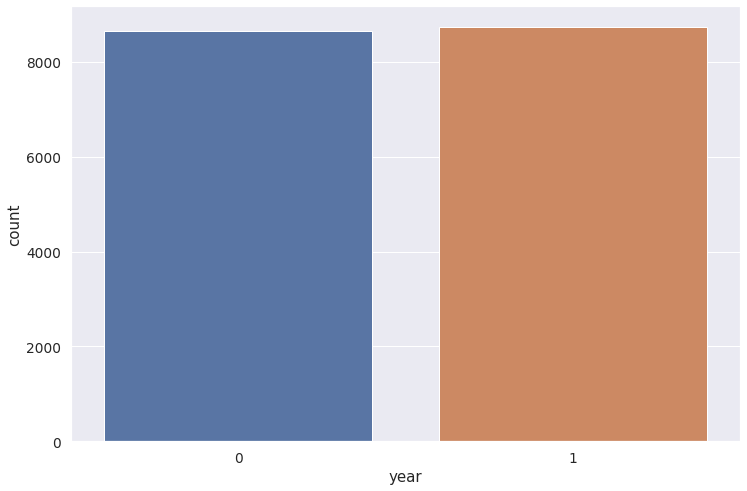

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


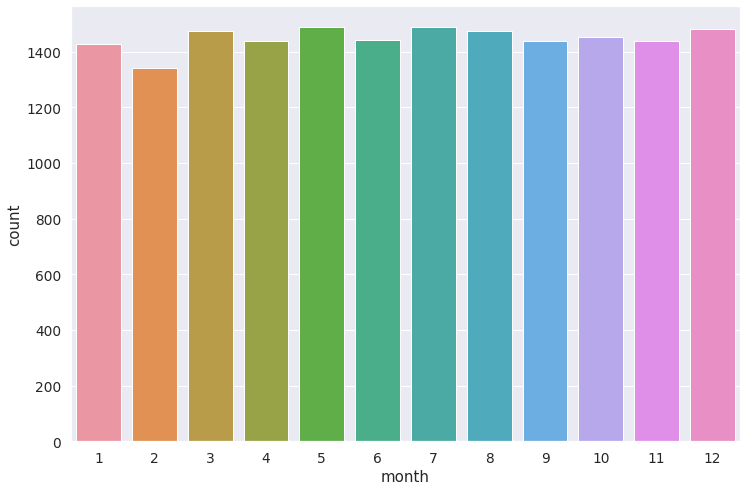

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


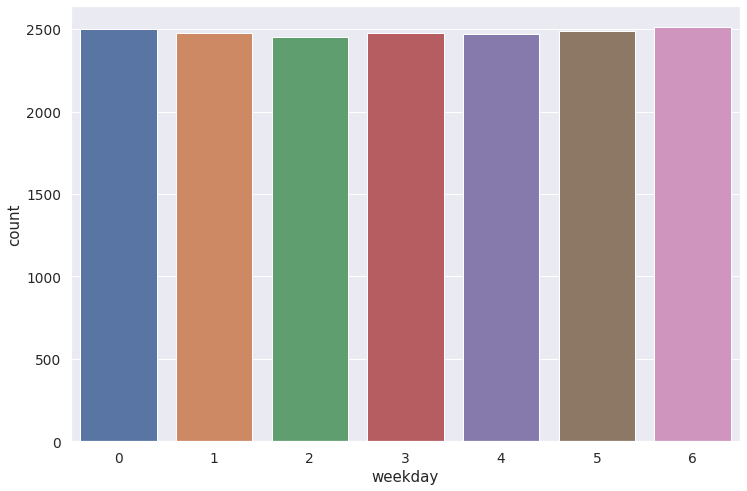

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


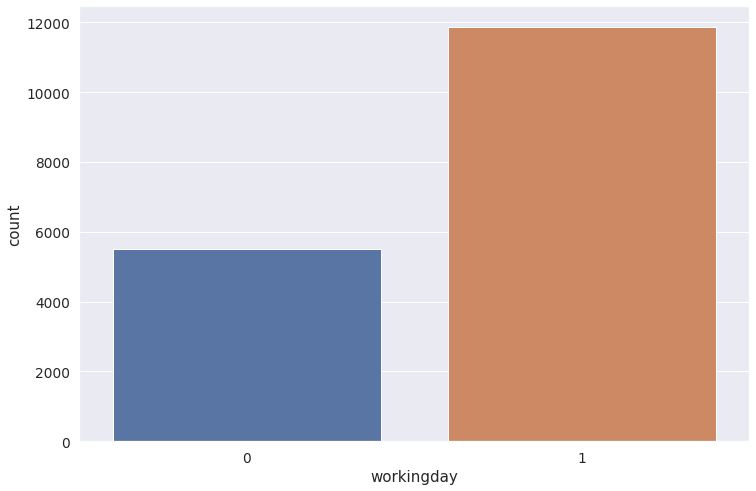

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


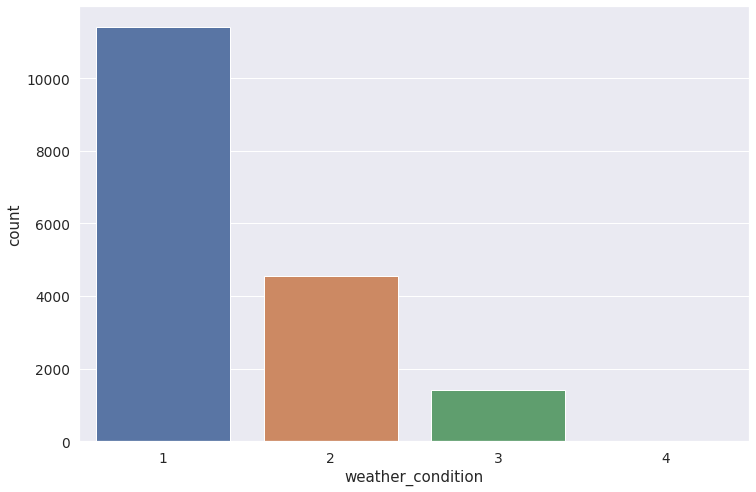

In [ ]:
for i in cat_col:
    sns.countplot(data[i])
    plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


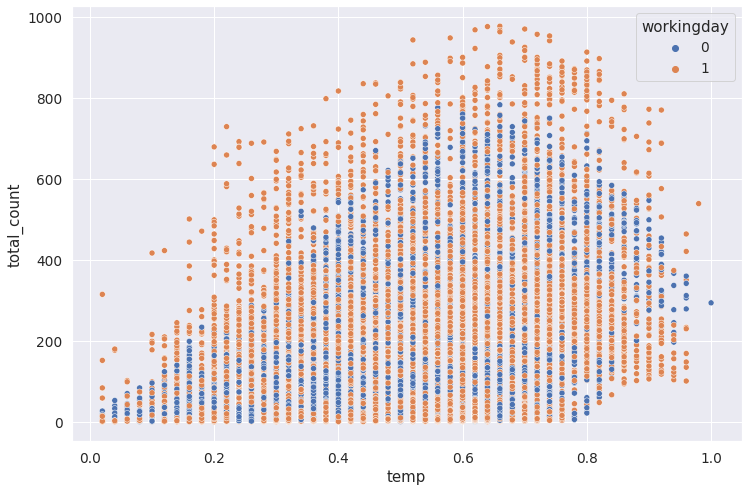

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


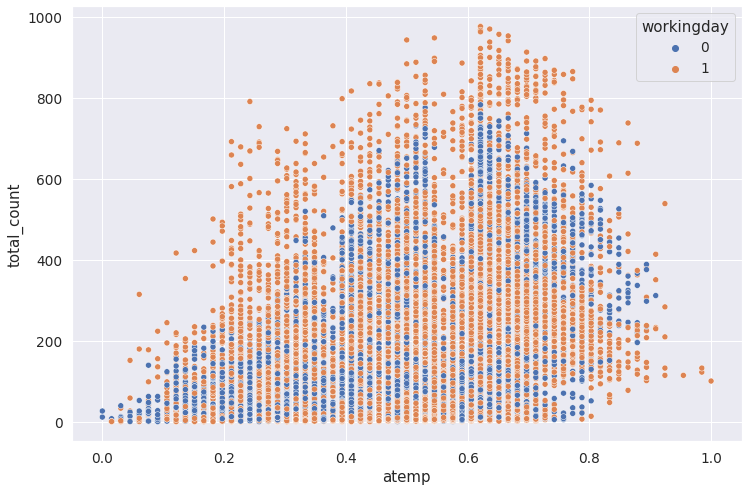

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


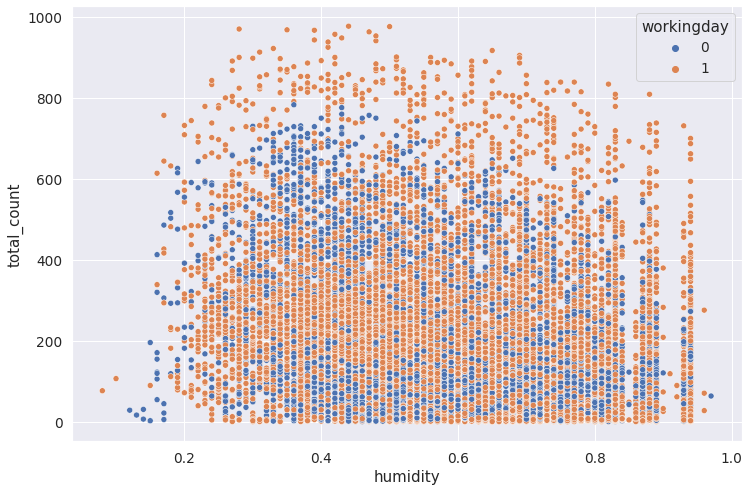

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


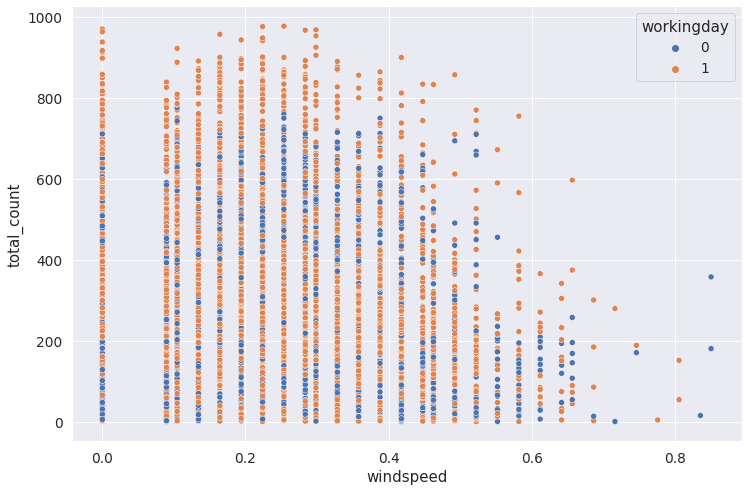

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


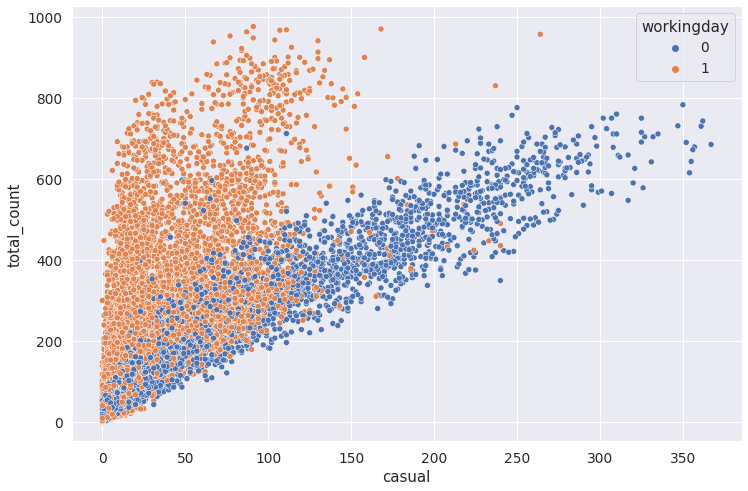

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


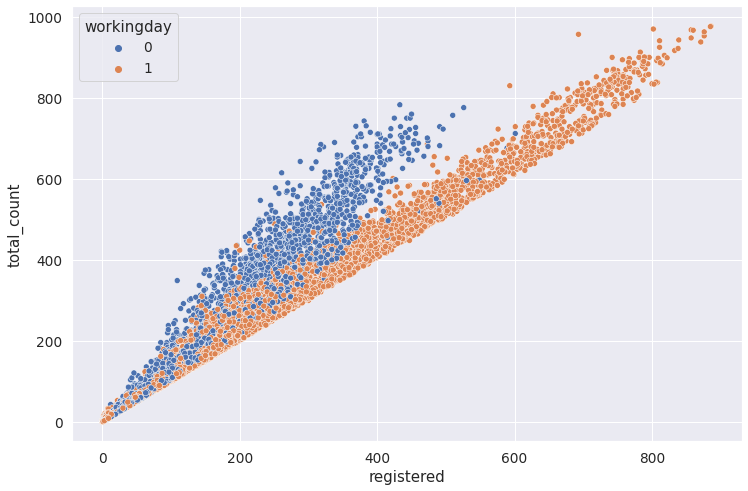

In [ ]:
# plotting graph b/w count and continuous columns taking working_day as hue
for i in cont_col:
    sns.scatterplot(data[i], data['total_count'], hue = data['workingday'])
    plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


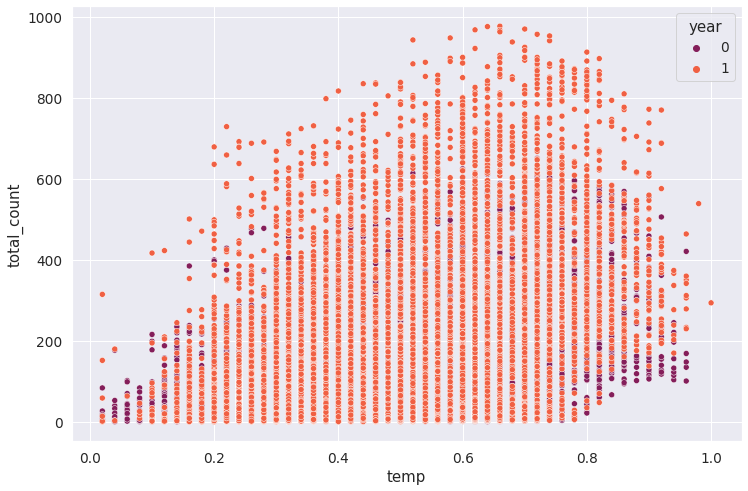

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


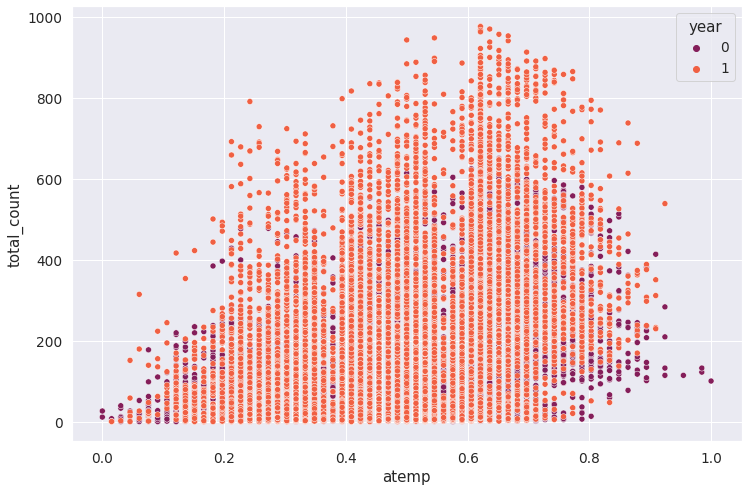

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


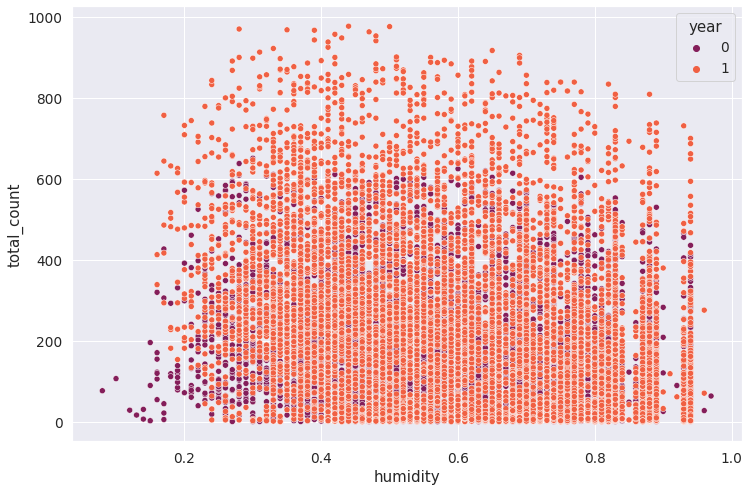

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


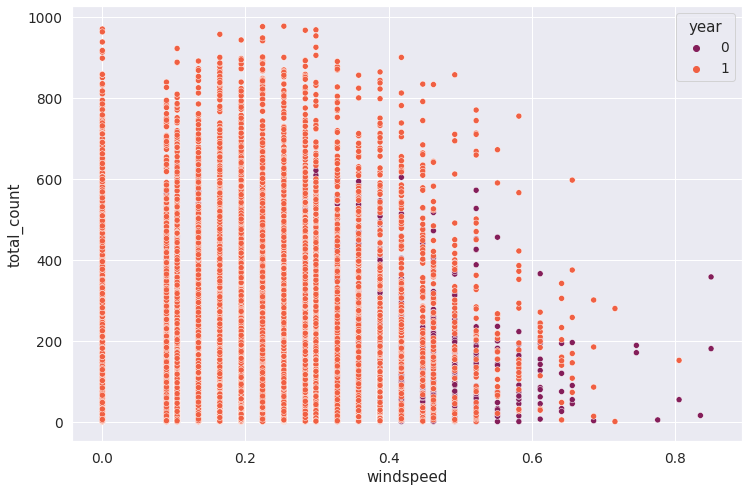

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


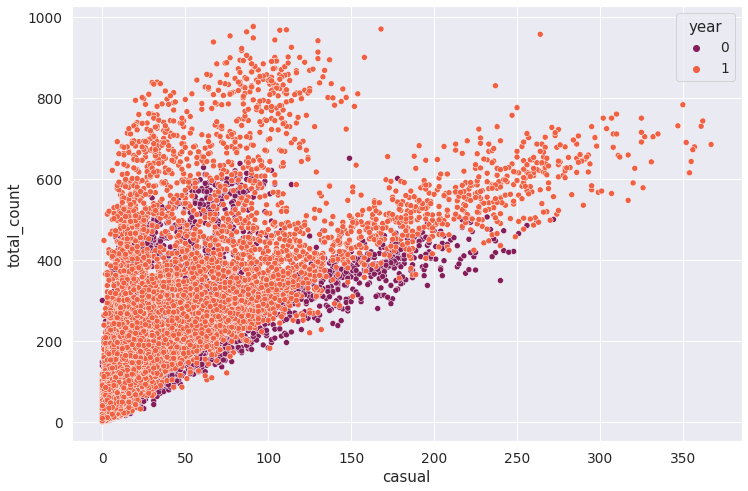

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


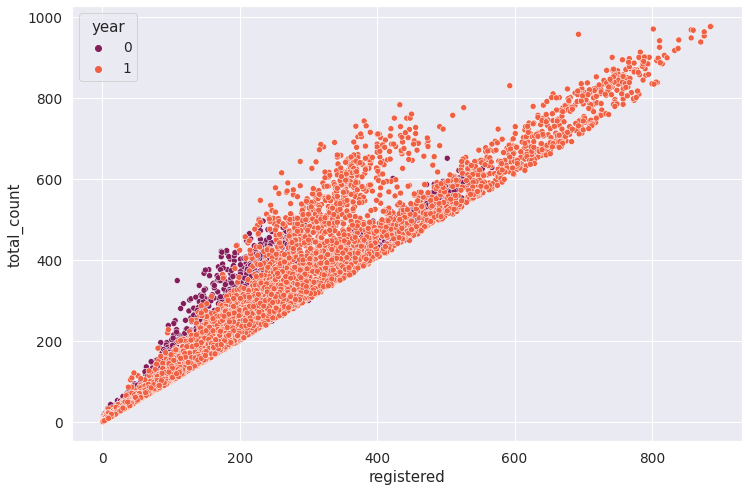

In [ ]:
for i in cont_col:
    sns.scatterplot(data[i], data['total_count'], hue = data['year'], palette = 'rocket')
    plt.show()

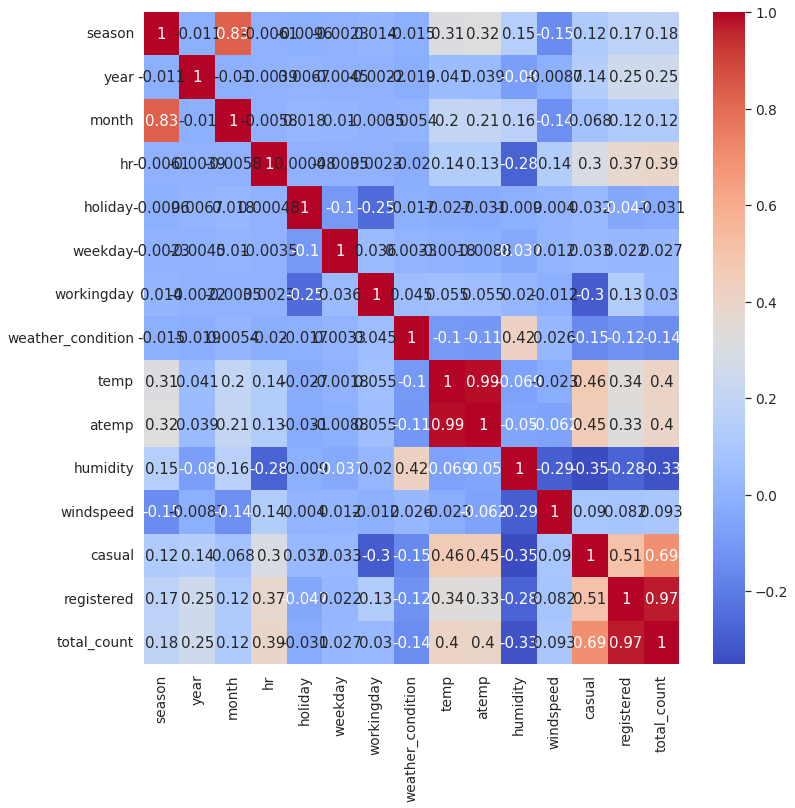

In [ ]:
df = data
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

In [ ]:
# # One-hot encode the categorical variables
# data = pd.get_dummies(data, columns=['season', 'weather_condition', 'weekday'])



I decided not to use one-hot encoding due to the task (i.e. I have to create exogenous variables).

In [ ]:
data.dtypes

datetime             datetime64[ns]
season                        int64
year                          int64
month                         int64
hr                            int64
holiday                       int64
weekday                       int64
workingday                    int64
weather_condition             int64
temp                        float64
atemp                       float64
humidity                    float64
windspeed                   float64
casual                        int64
registered                    int64
total_count                   int64
dtype: object

# I used my previous HW to provide EDA
# please find the link: https://colab.research.google.com/drive/145q--bo0WrTbVBwcrgz6BMtC158aSvYD?usp=sharing

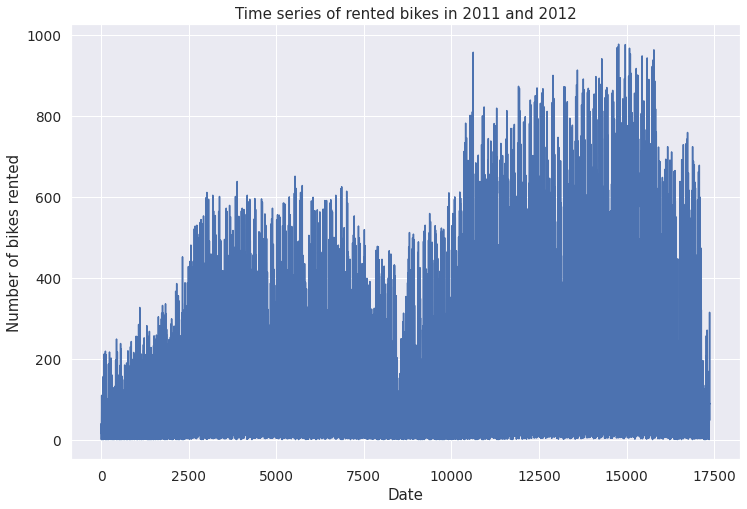

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


plt.plot(df['total_count'])
plt.xlabel('Date')
plt.ylabel('Number of bikes rented')
plt.title('Time series of rented bikes in 2011 and 2012')
plt.show()


Text(0, 0.5, 'Price Close')

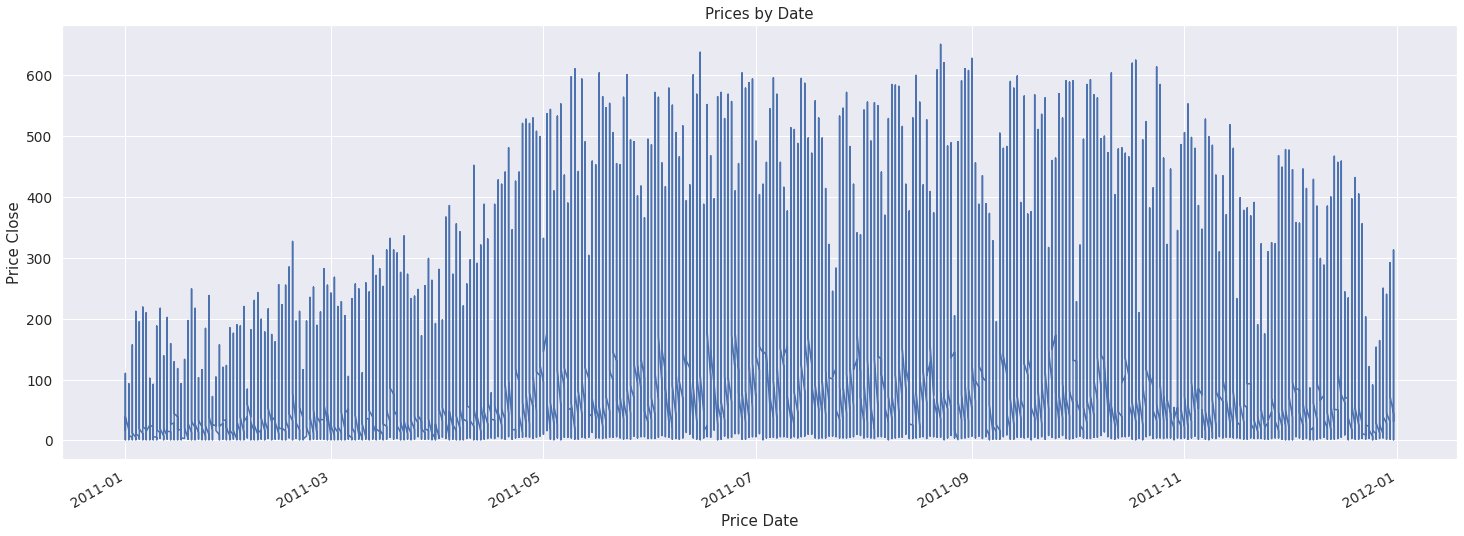

In [ ]:
# Plot year 2011

# Loading the dataset
df_2011 = data[data["datetime"].dt.year == 2011]

# X axis is price_date
price_date = df_2011['datetime']

# Y axis is price closing
price_close = df_2011['total_count']
plt.figure().set_figwidth(25)

# Plotting the timeseries graph of given dataset
plt.plot(price_date, price_close)

# Giving title to the graph
plt.title('Prices by Date')

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')



# Giving x and y label to the graph
plt.xlabel('Price Date')
plt.ylabel('Price Close')


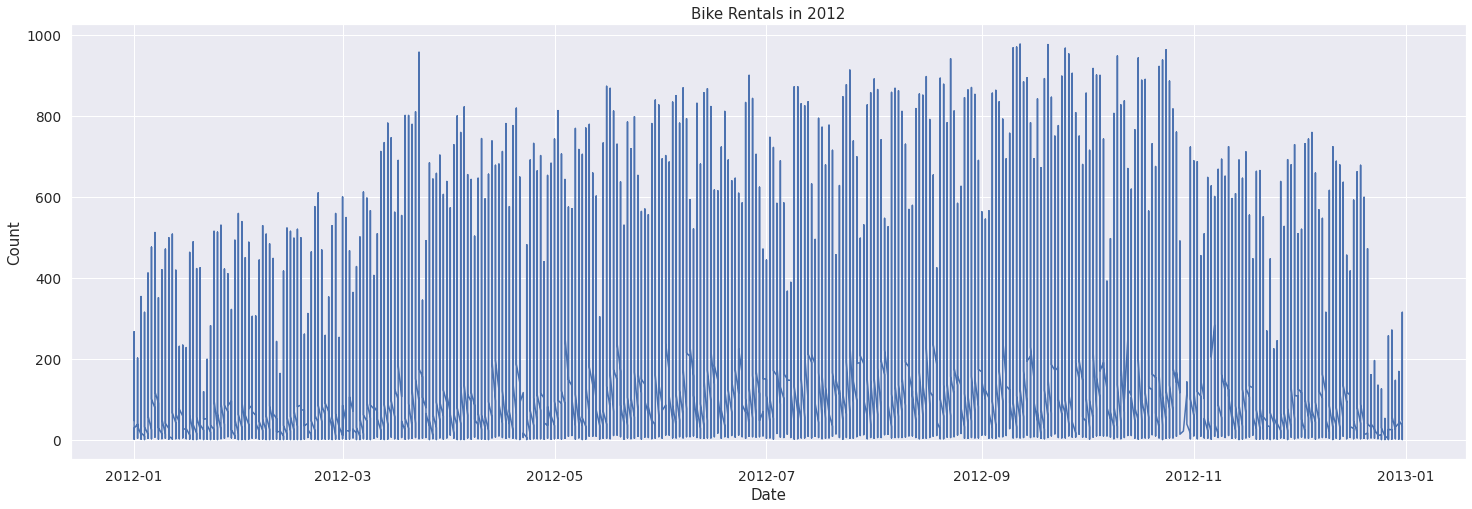

In [ ]:
# Plot year 2012
df_2012 = data[data["datetime"].dt.year == 2012]
plt.figure().set_figwidth(25)


# Create the plot
plt.plot(df_2012["datetime"], df_2012["total_count"])

plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Bike Rentals in 2012")
plt.show()


# 1.1. Statioanary analysis

In [ ]:
y = data['total_count']

alpha = 0.05
print(f"alpha = {alpha}\n")

# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")  

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.823
p-value: 1.981e-09
The process is stationary.


**ADF has a negative value, and p is lower than 0.05, so I can reject H0 --> The process is stationary, so I do not need to differentiate the dataset.**

In [ ]:
# Just doublecheck the stationary

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# # Load the time series data
# data3 = pd.read_csv('data.csv', parse_dates=['dteday'], index_col='dteday')

# Perform the ADF test
result = adfuller(data['total_count'])
p_value = result[1]
if p_value < 0.05:
    print('p_value =', p_value, '--> The time series is stationary.')
else:
    print('The time series is non-stationary.')

p_value = 1.9808626277977946e-09 --> The time series is stationary.


# 1.2. Decomposition

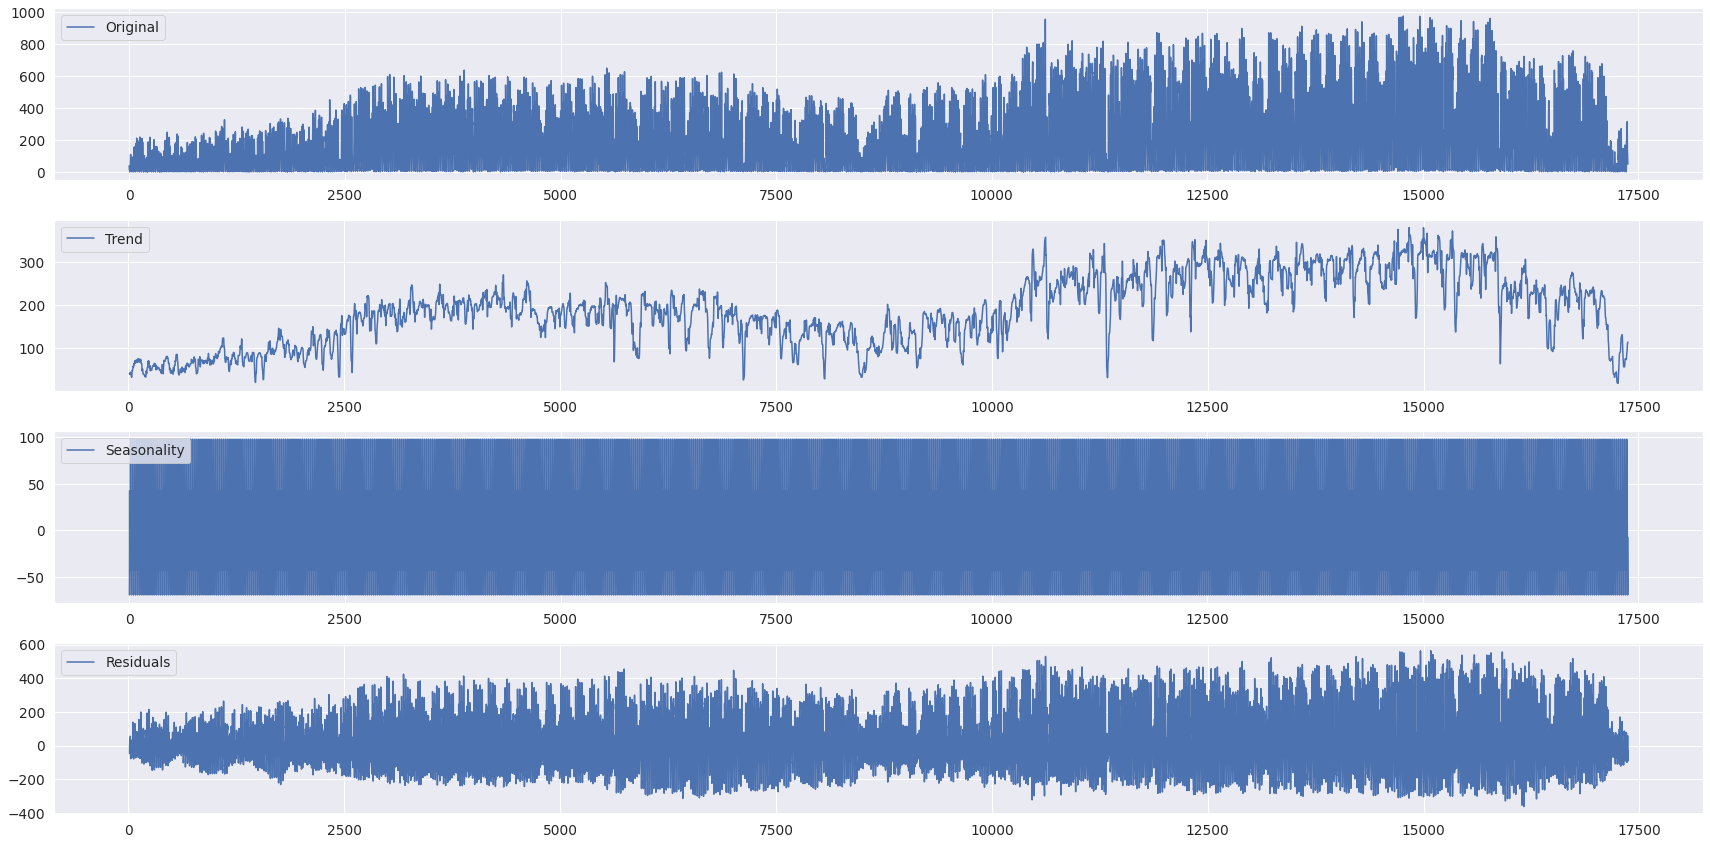

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(data['total_count'], model='additive', period=24)

# Plot the decomposition components
plt.figure(figsize=(24,12))
plt.subplot(411)
plt.plot(data['total_count'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


The decomposition separates the original time series into three components: trend, seasonal, and residual. 

--> The trend component captures the long-term changes or growth in the time series, 

--> the seasonal component represents the repeated patterns or cycles at a fixed frequency, 

--> residual component is the remainder after removing the trend and seasonal components. 

The analysis of the decomposition can help identify patterns and trends in the time series, as well as seasonality and irregularities.

The seasonal decomposition using an additive model with a period of 24 indicates that the time series data consists of a trend component, a seasonal component with a 24-hour cycle, and a remainder component representing the residuals or noise. 

The trend component appears to be increasing over time, and the seasonal component exhibits a repeating pattern with peaks around the same time each day. The remainder component appears to have some variability, but no clear pattern. 

Overall, the decomposition suggests that the time series data has some underlying patterns that can be separated and analyzed separately.

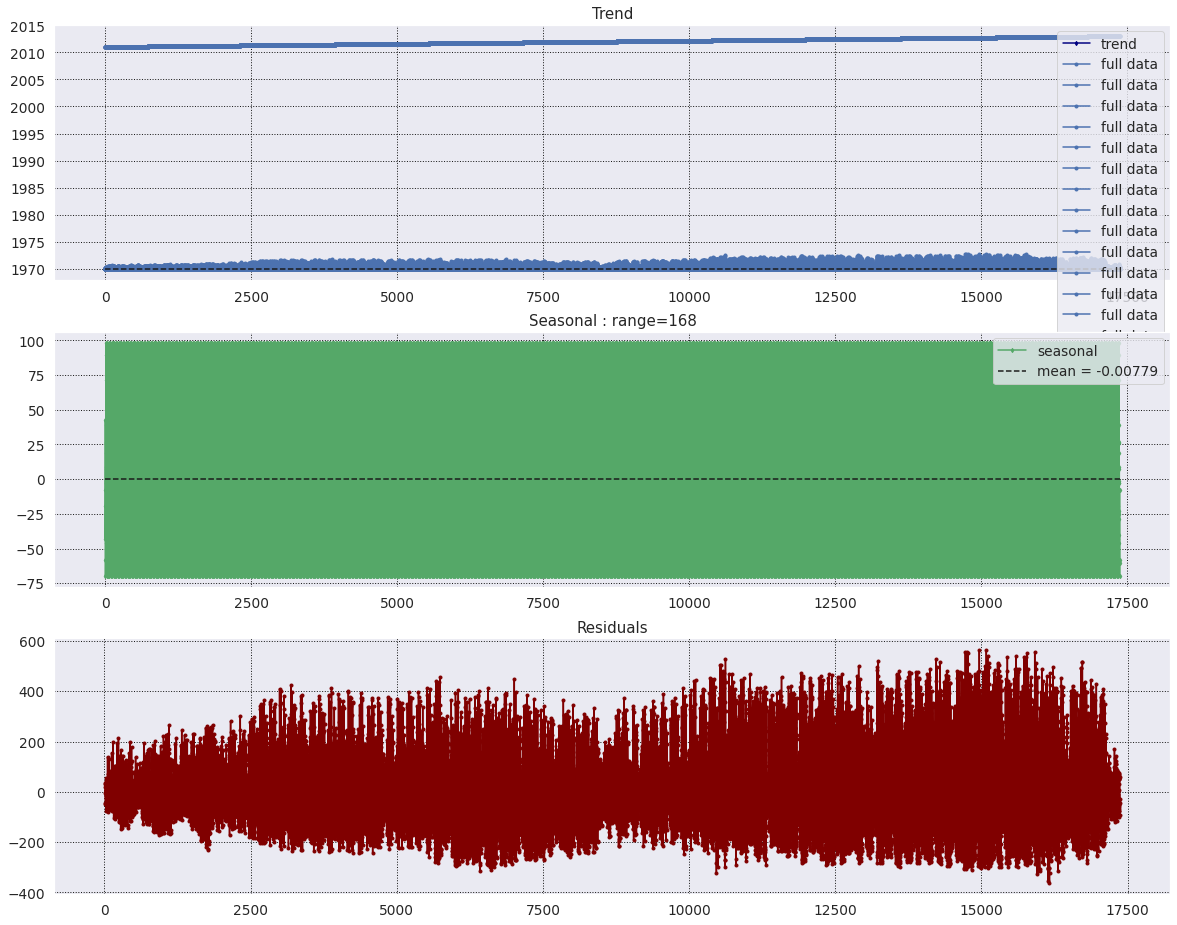

In [ ]:
decomposition = seasonal_decompose(y, model='additive', period=24)

plt.subplots(3, 1, figsize=(20, 16))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, 
         '-d', color='navy', markersize=3, label='trend')
plt.plot(data, '-bo', markersize=3, label='full data')
# plt.plot(decomposition.trend.index[0], 0)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, 
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]], 
         decomposition.seasonal.mean()*np.array([1, 1]), '--k', 
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


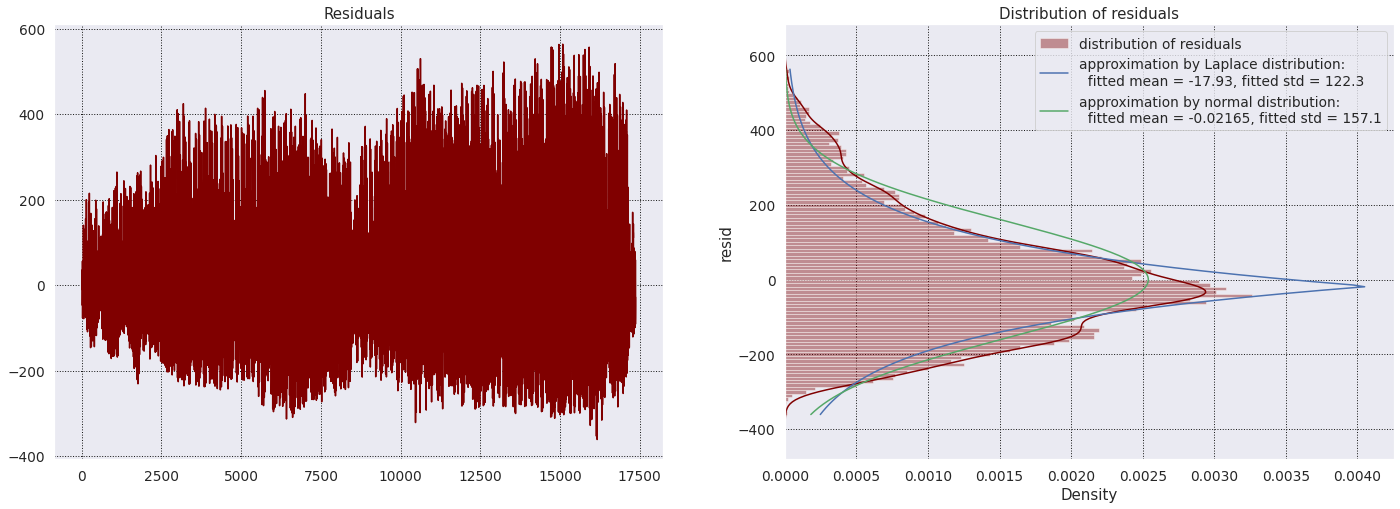

In [ ]:
import numpy as np
from scipy.stats import norm

resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")

x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())

# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b', 
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g', 
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

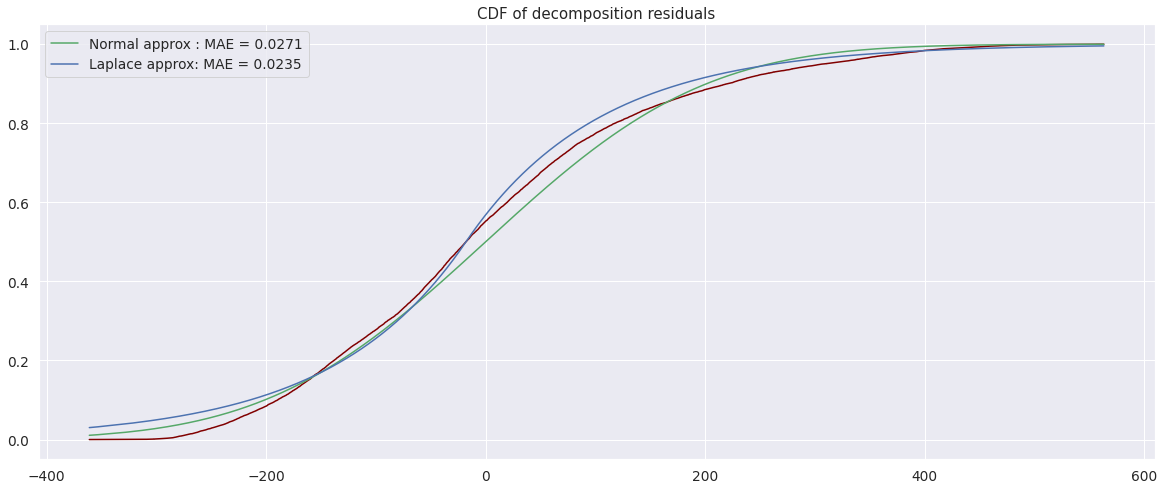

MAE_Gaussian/MAE_Laplace = 1.15.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g', 
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b', 
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

In general, the lower the MAE, the better the model predicts.

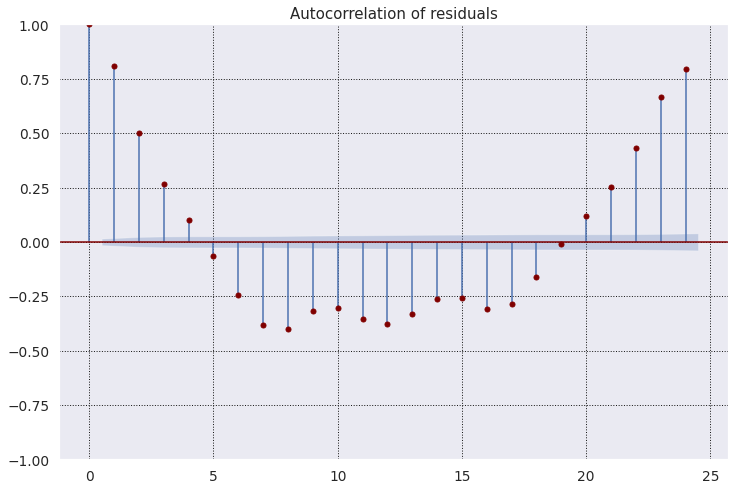

In [ ]:
lags = 24

plot_acf(resid.dropna(), lags=lags, color='maroon', 
         title='Autocorrelation of residuals');
plt.grid(linestyle=':', color='k')
plt.show()

We can see that there is a strong positive correlation at a lag of 24 (i.e., one day), this would suggest that there is a daily pattern in the data, which could be due to factors such as weekday vs weekend, time of day, or seasonality.

Correlation analysis 

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


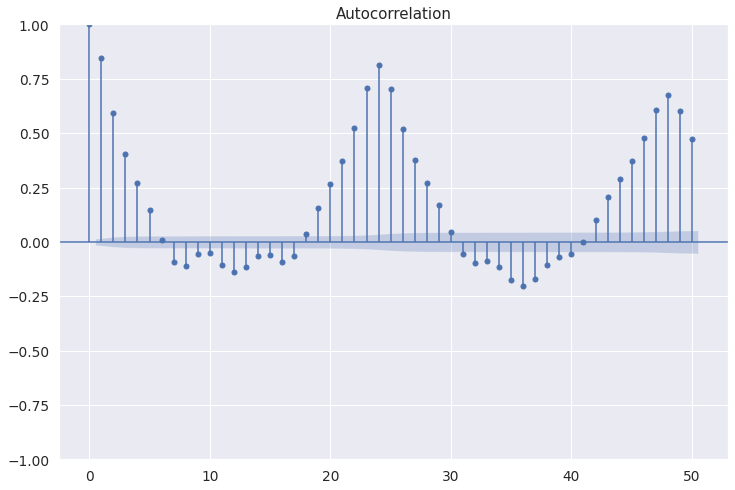

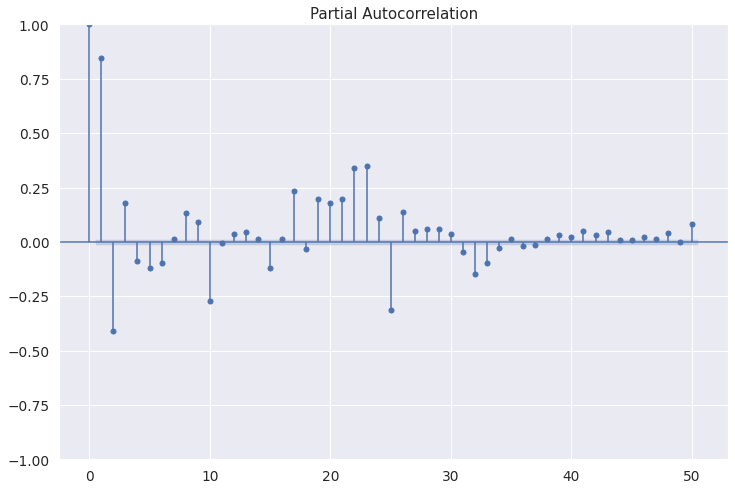

In [ ]:
# Perform correlation analysis
acf = plot_acf(data["total_count"], lags=50)
pacf = plot_pacf(data["total_count"], lags=50)
plt.show()

If we take a look at the ACF plot, we can see that there is a strong positive correlation between the "total_count" values and its first few lags, up to around lag 5. This suggests that the "total_count" values are highly dependent on their own past values up to around 5 hours ago. There is also a significant negative correlation at lag 24, which indicates a strong daily seasonality in the data.

If we investigate the PACF plot, we see a significant spike at lag 1, which suggests that the "total_count" values are highly correlated with their immediate past value. There is also a significant spike at lag 24, indicating that the daily seasonality is still present after removing the effects of the intermediate lags.

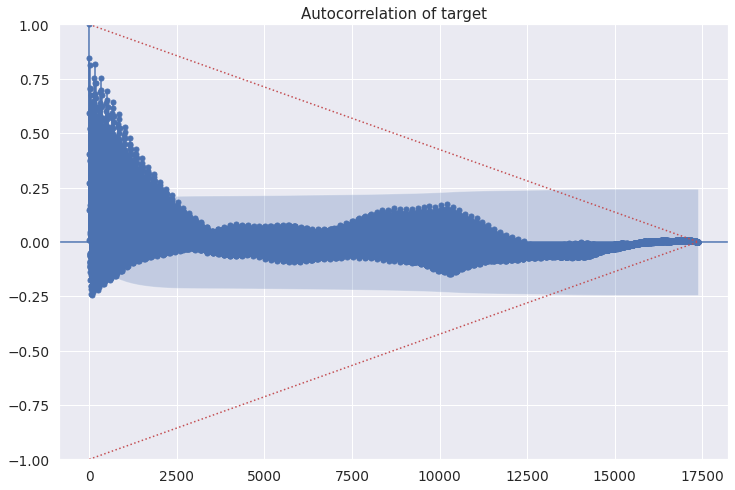

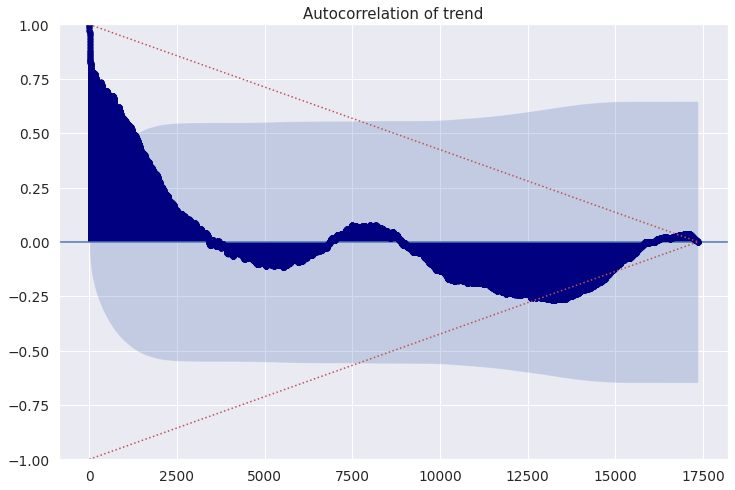

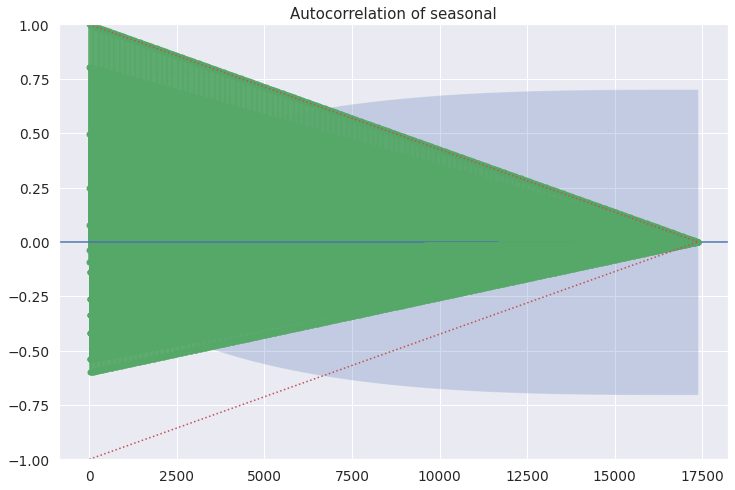

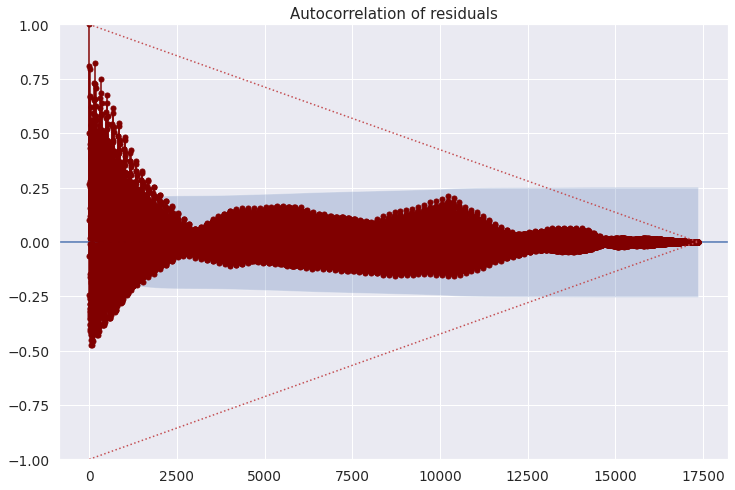

In [ ]:
N = len(y)
k = np.arange(0, N)
plot_acf(y, 
         lags=N-1, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')

trend = decomposition.trend.dropna()
N = len(trend)
k = np.arange(0, N)
plot_acf(trend, 
         lags=N-1, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal, 
         lags=N-1, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(), 
         lags=N-1,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

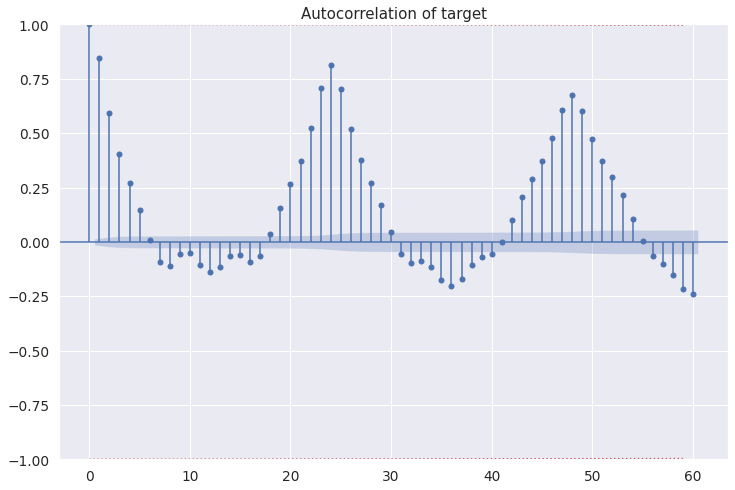

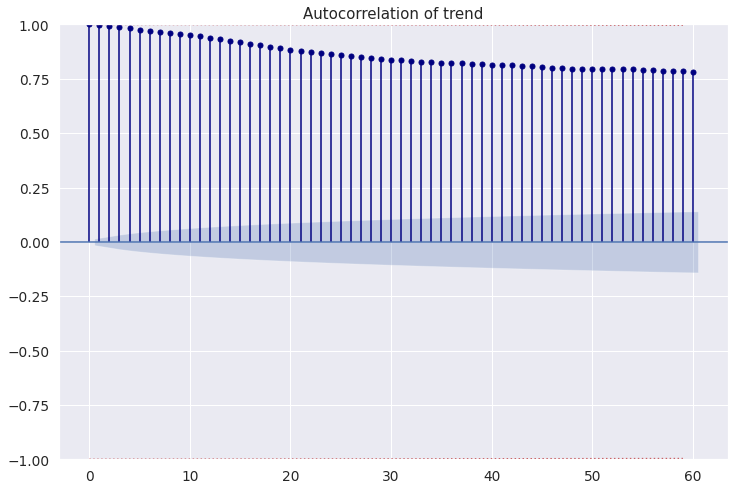

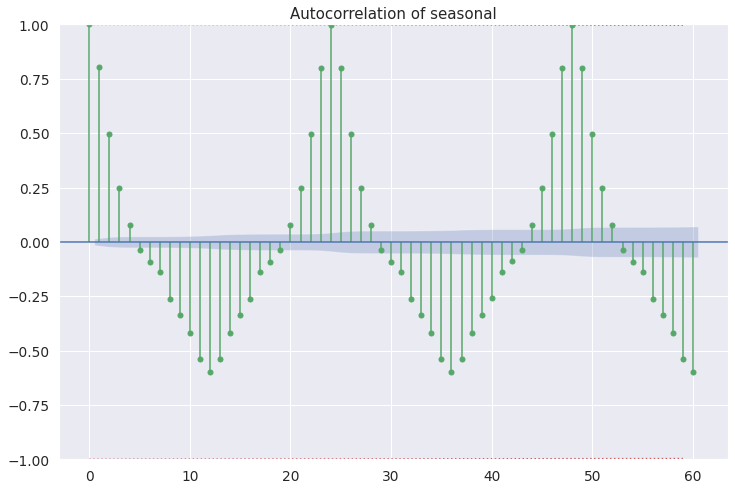

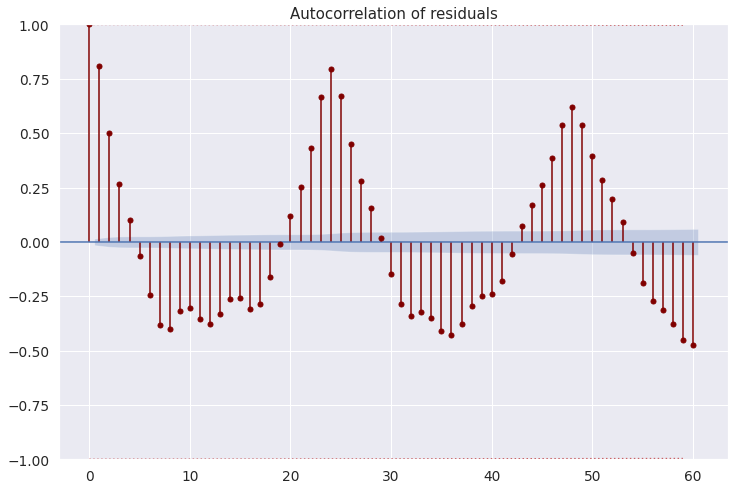

In [ ]:
lags = 60

N = len(y)
k = np.arange(0, lags)
plot_acf(y, 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend)
plot_acf(trend, 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
plot_acf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
plot_acf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

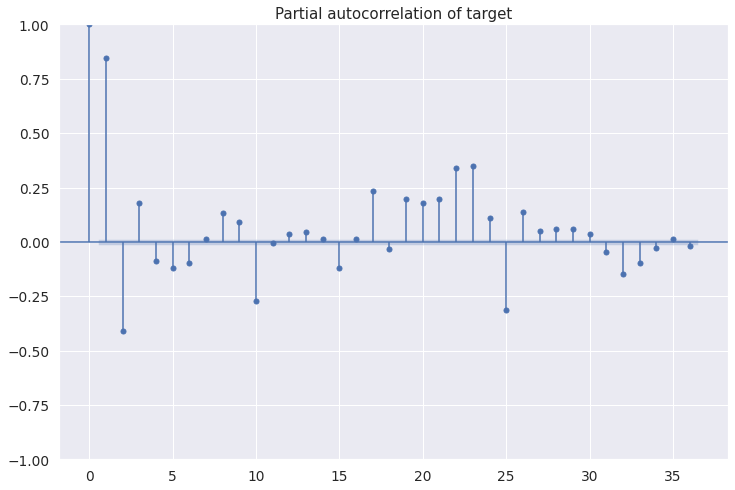

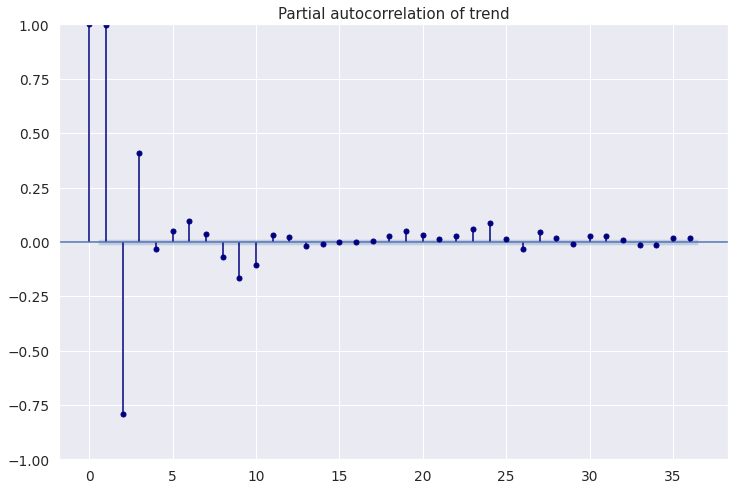

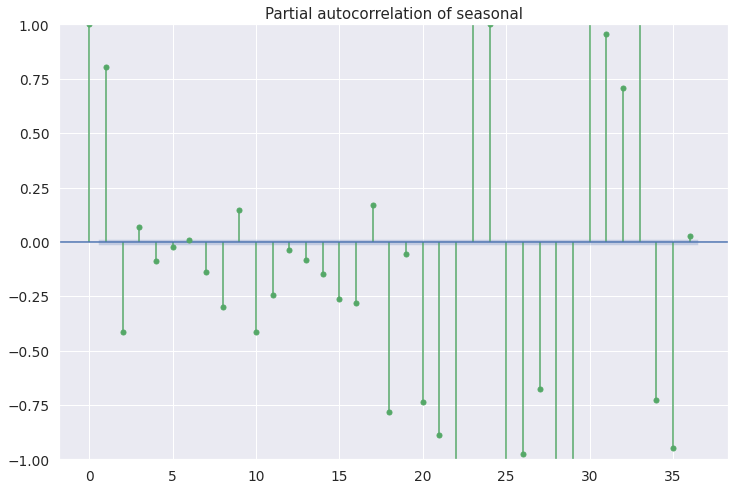

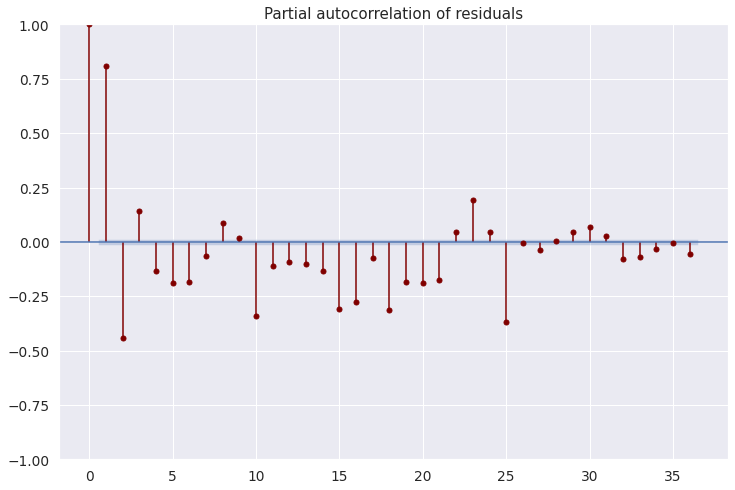

In [ ]:
lags = 36

plot_pacf(y, 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Partial autocorrelation of target');
         

plot_pacf(trend.dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of trend');


seasonal = decomposition.seasonal
plot_pacf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Partial autocorrelation of seasonal');


plot_pacf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Partial autocorrelation of residuals');


plt.show()

# 2. construct the baseline model

In [ ]:
import pandas as pd

# Load the data into a pandas DataFrame
data = data

# Convert the "dteday" column to a datetime object
data["datetime"] = pd.to_datetime(data["datetime"])

# Extract additional features from the datetime column
data["day"] = data["datetime"].dt.day
data["weekday"] = data["datetime"].dt.weekday

# Create a new variable "season_name" based on the "season" column
season_map = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
data["season_name"] = data["season"].map(season_map)

# Create a new variable "is_weekend" based on the "weekday" column
data["is_weekend"] = data["weekday"].isin([5, 6])

# Create a new variable "is_holiday" based on the "holiday" column
data["is_holiday"] = data["holiday"].astype(bool)

# Create a new variable "is_workingday" based on the "workingday" column
data["is_workingday"] = data["workingday"].astype(bool)

# Create a new variable "is_rush_hour" based on the "hour" column
data["is_rush_hour"] = data["hr"].isin([7, 8, 9, 16, 17, 18])



In [ ]:
data.head()

datetime  season  year  month  hr  holiday  weekday  workingday  \
0 2011-01-01       1     0      1   0        0        5           0   
1 2011-01-01       1     0      1   1        0        5           0   
2 2011-01-01       1     0      1   2        0        5           0   
3 2011-01-01       1     0      1   3        0        5           0   
4 2011-01-01       1     0      1   4        0        5           0   

   weather_condition  temp  ...  windspeed  casual  registered  total_count  \
0                  1  0.24  ...        0.0       3          13           16   
1                  1  0.22  ...        0.0       8          32           40   
2                  1  0.22  ...        0.0       5          27           32   
3                  1  0.24  ...        0.0       3          10           13   
4                  1  0.24  ...        0.0       0           1            1   

   day  season_name  is_weekend is_holiday  is_workingday  is_rush_hour  
0    1       spring        True      False          False         False  
1    1       spring        True      False          False         False  
2    1       spring        True      False          False         False  
3    1       spring        True      False          False         False  
4    1       spring        True      False          False         False  

[5 rows x 22 columns]

In [ ]:
data.dtypes

datetime             datetime64[ns]
season                        int64
year                          int64
month                         int64
hr                            int64
holiday                       int64
weekday                       int64
workingday                    int64
weather_condition             int64
temp                        float64
atemp                       float64
humidity                    float64
windspeed                   float64
casual                        int64
registered                    int64
total_count                   int64
day                           int64
season_name                  object
is_weekend                     bool
is_holiday                     bool
is_workingday                  bool
is_rush_hour                   bool
dtype: object

In [ ]:
def evaluate_model(est, X_train, X_test, y_train, y_test):
    est.fit(X_train, y_train)
    y_tr_pred = est.predict(X_train)
    y_test_pred = est.predict(X_test)
    r2_train = r2_score(y_train, y_tr_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R2 Train Score: {r2_train}')
    print(f'R2 Test Score: {r2_test}')
    print(f'R2 adjusted Train Score: {1 - ((1 - r2_train) * ((len(X_train) - 1) / (len(X_train) - len(X_train.columns) - 1)))}')
    print(f'R2 adjusted Test Score: {1 - ((1 - r2_test) * ((len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)))}')
    print(f'MAE Train: {mean_absolute_error(y_train, y_tr_pred)}')
    print(f'MAE Test: {mean_absolute_error(y_test, y_test_pred)}')

In [ ]:
# Endogenous model

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# load data
# data = data

# split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# define endogenous variables
endogenous_vars = ['season', 'year', 'month', 'hr', 'holiday', 'weekday', 'workingday',
                   'day', 'is_weekend', 'is_holiday', 'is_workingday', 'is_rush_hour']

X_train = train[endogenous_vars]
y_train = train['total_count']
X_test = test[endogenous_vars]
y_test = test['total_count']

# fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predict on test set
y_pred = lr_model.predict(X_test)

# calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print('Baseline Model MAE:', mae)


Baseline Model MAE: 132.57559853084604


In [ ]:
evaluate_model(lr_model, X_train, X_test, y_train, y_test)

R2 Train Score: 0.4444278424628141
R2 Test Score: 0.062181427497167374
R2 adjusted Train Score: 0.44402680385053994
R2 adjusted Test Score: 0.0467440847399192
MAE Train: 100.92337885209052
MAE Test: 132.57559853084604


In [ ]:
# create exogenous variables related to weather
data['weather_good'] = np.where(data[['weather_condition']].isin([1,2]), 1, 0)
data['temp_norm'] = (data['temp'] - data['temp'].mean()) / data['temp'].std()
data['atemp_norm'] = (data['atemp'] - data['atemp'].mean()) / data['atemp'].std()

In [ ]:
# ENDO + EXO model

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# load data
data = data

# split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# define endogenous variables
endogenous_vars = ['season', 'year', 'month', 'hr', 'holiday', 'weekday', 'workingday',
                   'day', 'is_weekend', 'is_holiday', 'is_workingday', 'is_rush_hour']

exogenous_vars = ['weather_good','temp_norm', 'atemp_norm']

X_train = train[endogenous_vars + exogenous_vars]
y_train = train['total_count']
X_test = test[endogenous_vars + exogenous_vars]
y_test = test['total_count']

# fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predict on test set
y_pred = lr_model.predict(X_test)

# calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print('Baseline Model MAE:', mae)



Baseline Model MAE: 96.01162650479988


In [ ]:
evaluate_model(lr_model, X_train, X_test, y_train, y_test)

R2 Train Score: 0.536593722378174
R2 Test Score: 0.4146329302447732
R2 adjusted Train Score: 0.5361755108286688
R2 adjusted Test Score: 0.4025385692994172
MAE Train: 93.14222460923547
MAE Test: 96.01162650479988


We can see that the model performs significantly better if we use exogenous variables. Using only endogenous variables the value of MAE was 132.575, but after the addition of exogenous variables MAE decresed to 96.011. (Still high, but way better performance.) 

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


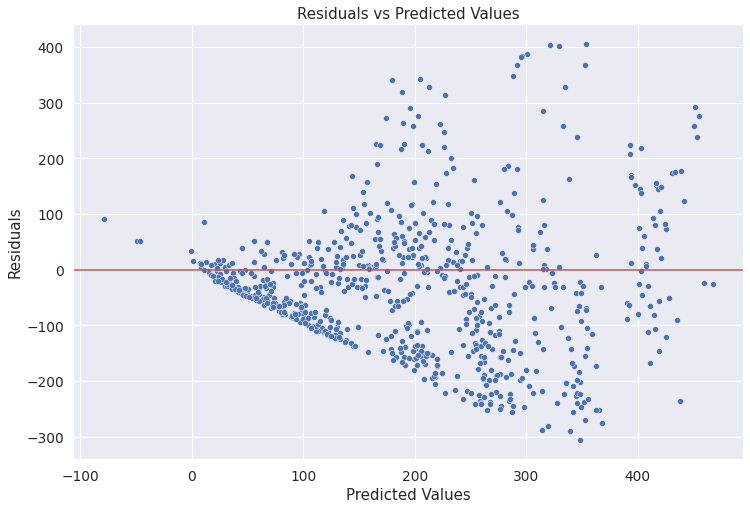

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


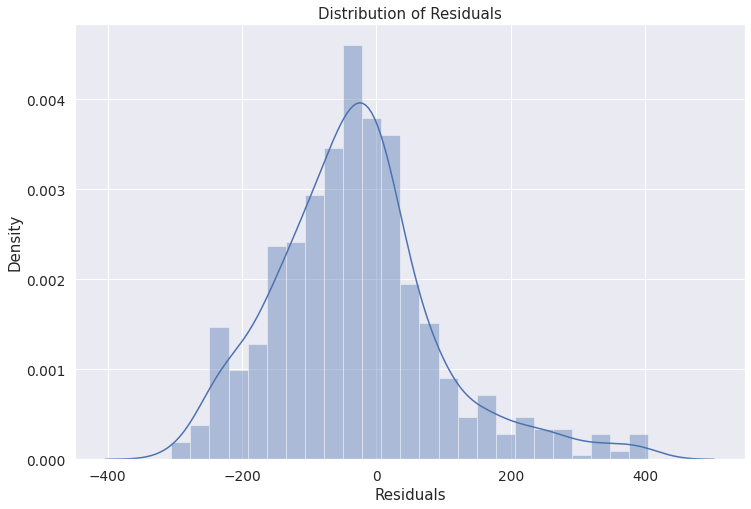

In [ ]:
# Residual analysis

# Make predictions on test data
y_pred = lr_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs predicted values
sns.scatterplot(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Plot distribution of residuals
sns.distplot(residuals)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()


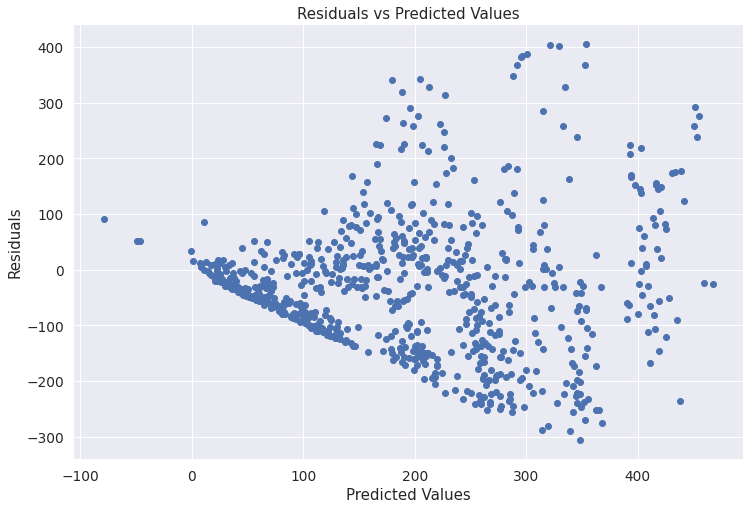

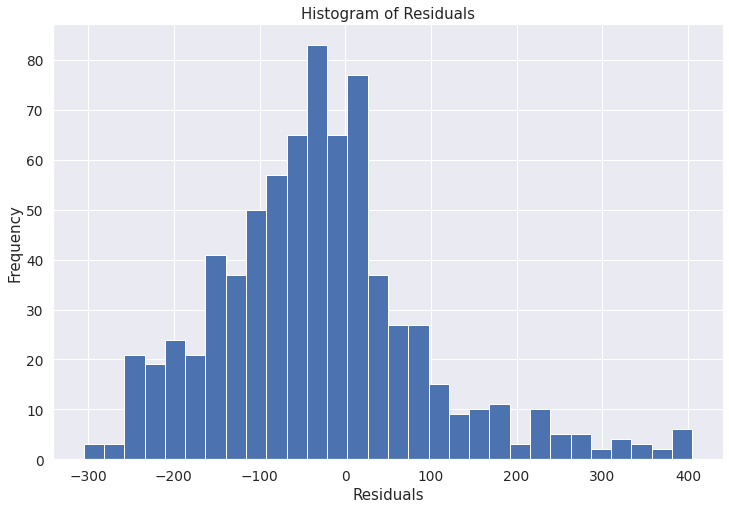

In [ ]:
# Predict on test data
y_pred = lr_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs predicted values
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Plot histogram of residuals
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Perform Ljung-Box test for autocorrelation of residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set lag value for autocorrelation test
lag = 20

# Calculate Ljung-Box test statistic and p-values
lbvalue, pvalue = acorr_ljungbox(residuals, lags=lag)





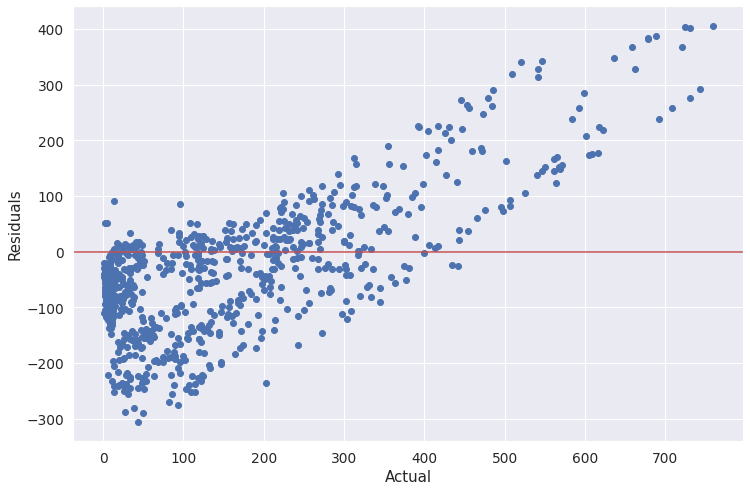

Durbin-Watson test statistic: 0.7053710918101939


In [ ]:
# Make predictions on test set
y_pred = lr_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals to check for patterns
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.show()

# Check for white noise using the Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(residuals)
print("Durbin-Watson test statistic:", dw_test)

# If the Durbin-Watson test statistic is close to 2, then there is no autocorrelation in the residuals and they are white noise.


The scatter plot of residuals shows no clear patterns, which is encouring. The red line at y=0 shows the mean of residuals, which is close to 0, indicating that the model is predicting well. The Durbin-Watson test statistic is 0.705, which is not too close to 2, indicating that there is is some autocorrelation in the residuals and they are probably not white noise.

# 3. ARIMA

# Arima model 1

                               SARIMAX Results                                
Dep. Variable:            total_count   No. Observations:                16637
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -98032.414
Date:                Tue, 14 Mar 2023   AIC                         196072.829
Time:                        14:33:11   BIC                         196103.706
Sample:                             0   HQIC                        196083.022
                              - 16637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.4770      5.892     32.328      0.000     178.929     202.025
ar.L1          0.7309      0.006    120.734      0.000       0.719       0.743
ma.L1          0.5112      0.008     65.693      0.0

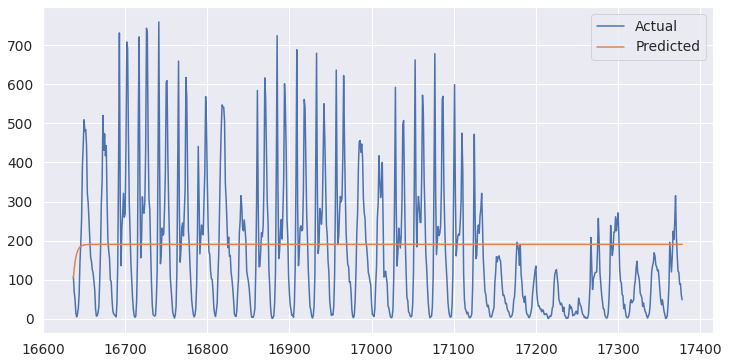

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the data

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# Fit an ARIMA model to the training data
model = ARIMA(train['total_count'], order=(1, 0, 1))
model_fit = model.fit()

# Print the summary of the fitted model
print(model_fit.summary())

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Plot the predicted values against the actual values
plt.figure(figsize=(12,6))
plt.plot(test['total_count'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


As my basic ARIMA, I set p and q to 1, and d = 0, becasuse I wanted to check the result without differentation, and with 1 leg of AR and MA.

Interpretation: If each term have a p-value of less than 0.05 in 'SARIMAX result' table, so we can reject the null hypothesis with statistically significant values. So ar.L1 and ma.L1 and sigma 2 are significant

The Ljung-Box (L1) (Q) is the LBQ test statistic at lag 1 is 1.21, the Prob(Q) is 0.27, so the probability is above 0.05, we can’t reject the null that the errors are white noise.

In the next step I tried to reveal Ljung-Box test statistics and p-values for the lags, hence I used a Ljung-Box diagnostic function.


If we analyse heteroskedasticity, H0 (null hypothesis): data is homoscedastic. Ha (alternative hypothesis): data is heteroscedastic. Therefore, if the p-value associated to a heteroscedasticity test falls below a certain threshold (0.05 for example), we would conclude that the data is significantly heteroscedastic.
Homoscedasticity is preferred, of course.

In [ ]:
# Calculate R2 train score
y_train_pred = model_fit.predict(start=0, end=len(train)-1, typ='levels')
r2_train = r2_score(train['total_count'], y_train_pred)

# Calculate R2 test score
r2_test = r2_score(test['total_count'], predictions)

# Calculate adjusted R2 train score
adj_r2_train = 1 - (1 - r2_train) * (len(train) - 1) / (len(train) - train.shape[1] - 1)

# Calculate adjusted R2 test score
adj_r2_test = 1 - (1 - r2_test) * (len(test) - 1) / (len(test) - train.shape[1] - 1)

# Calculate MAE train score
mae_train = mean_absolute_error(train['total_count'], y_train_pred)

# Calculate MAE test score
mae_test = mean_absolute_error(test['total_count'], predictions)

# Print the metrics
print(f"R2 Train Score: {r2_train:.4f}")
print(f"R2 Test Score: {r2_test:.4f}")
print(f"Adjusted R2 Train Score: {adj_r2_train:.4f}")
print(f"Adjusted R2 Test Score: {adj_r2_test:.4f}")
print(f"MAE Train Score: {mae_train:.4f}")
print(f"MAE Test Score: {mae_test:.4f}")


R2 Train Score: 0.7680
R2 Test Score: -0.0180
Adjusted R2 Train Score: 0.7677
Adjusted R2 Test Score: -0.0535
MAE Train Score: 58.3522
MAE Test Score: 135.9015


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
mod = ARIMA(train['total_count'], order=(1,0,1))
res = mod.fit()
jlung = acorr_ljungbox(res.resid)
jlung

lb_stat      lb_pvalue
1     15.909664   6.643861e-05
2     21.071524   2.656909e-05
3    115.292575   7.963338e-25
4    178.709296   1.411627e-37
5    226.241068   6.835940e-47
6    270.690218   1.543969e-55
7    498.255581  1.901152e-103
8   1421.163050  1.502761e-301
9   1888.789626   0.000000e+00
10  2023.177069   0.000000e+00

With the help of following script I wanted determine the optimal p,d,q numbers for ARIMA. Due to my earlier reselt (i.e: optimal lag number has to be around 5) nd the very long running time a set p and q range 0 to 6. Moreover: my dataset is stationary, so max number of d=2. 
Moreover I wanted to determine the seasonal_order (P,D,Q), but unfortunately my session crashed every time. So finally I did not run the scrip, but a simplified version in the next step.

In [ ]:
# import itertools

# # Define the range of values to search over for p, d, q, and P, D, Q
# p_values = range(0, 6)
# d_values = range(0, 2)
# q_values = range(0, 6)
# P_values = range(0, 3)
# D_values = range(0, 2)
# Q_values = range(0, 3)

# # Generate all possible combinations of p, d, q, and P, D, Q
# parameters = itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values)

# # Define a function to evaluate the ARIMA model with the given parameter values
# def evaluate_model(train, test, order, seasonal_order):
#     model = ARIMA(train['total_count'], order=order, seasonal_order=seasonal_order)
#     model_fit = model.fit()
#     predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
#     return predictions

# # Split data into train and test sets
# train = data[data['datetime'] < '2012-12-01']
# test = data[data['datetime'] >= '2012-12-01']

# # Iterate over all possible combinations of p, d, q, and P, D, Q, and evaluate each model
# best_score, best_cfg = float('inf'), None
# for param in parameters:
#     try:
#         order = (param[0], param[1], param[2])
#         seasonal_order = (param[3], param[4], param[5], 24) # 24 is the period of the seasonal component
#         predictions = evaluate_model(train, test, order, seasonal_order)
#         error = mean_squared_error(test['total_count'], predictions)
#         if error < best_score:
#             best_score, best_cfg = error, (order, seasonal_order)
#         print('ARIMA%s %s MSE=%.3f' % (order, seasonal_order, error))
#     except:
#         continue

# print('Best ARIMA%s %s MSE=%.3f' % (best_cfg[0], best_cfg[1], best_score))


With the help of following script I could determine the optimal p,d,q numbers for ARIMA. Due to my earlier reselt (i.e: optimal lag number has to be around 5) nd the very long running time a set p and q range 0 to 6. Moreover: my dataset is stationary, so max number of d=2. 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# fit ARIMA models with different (p, d, q) parameters
p_values = range(0, 6)
d_values = range(0, 2) # dataset is stationary, so max number of d = 2
q_values = range(0, 6)

best_aic, best_bic, best_model = float("inf"), float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train["total_count"], order=(p, d, q)).fit()
                aic = model.aic
                bic = model.bic
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                if bic < best_bic:
                    best_bic = bic
                    best_model = model
            except:
                pass

# print the best-fitting model and its AIC and BIC values
print("Best model: ", best_model.summary())
print("AIC: ", best_aic)
print("BIC: ", best_bic)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non

Best model:                                 SARIMAX Results                                
Dep. Variable:            total_count   No. Observations:                16637
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -96668.432
Date:                Tue, 14 Mar 2023   AIC                         193358.863
Time:                        15:04:43   BIC                         193443.776
Sample:                             0   HQIC                        193386.894
                              - 16637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0791      0.029     36.918      0.000       1.022       1.136
ar.L2         -0.6164      0.034    -18.013      0.000      -0.683      -0.549
ar.L3         -0.3359      0.040     -8

# Arima model 2

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            total_count   No. Observations:                16637
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -96668.432
Date:                Tue, 14 Mar 2023   AIC                         193358.863
Time:                        15:05:23   BIC                         193443.776
Sample:                             0   HQIC                        193386.894
                              - 16637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0791      0.029     36.918      0.000       1.022       1.136
ar.L2         -0.6164      0.034    -18.013      0.000      -0.683      -0.549
ar.L3         -0.3359      0.040     -8.486      0.0

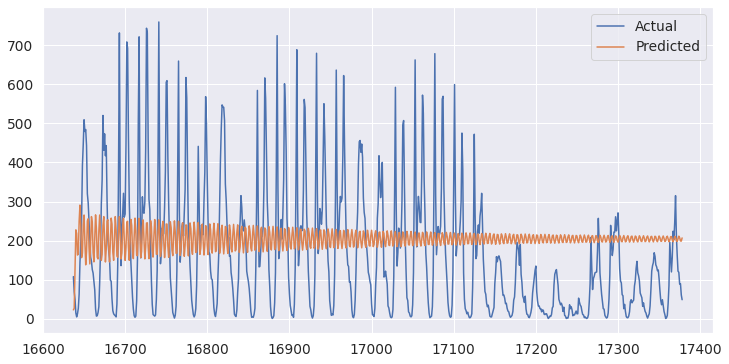

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# Train an ARIMA model
model = ARIMA(train['total_count'], order=(5,1,5))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Plot the predicted values against the actual values
plt.figure(figsize=(12,6))
plt.plot(test['total_count'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# Calculate R2 train score
y_train_pred = model_fit.predict(start=0, end=len(train)-1, typ='levels')
r2_train = r2_score(train['total_count'], y_train_pred)

# Calculate R2 test score
r2_test = r2_score(test['total_count'], predictions)

# Calculate adjusted R2 train score
adj_r2_train = 1 - (1 - r2_train) * (len(train) - 1) / (len(train) - train.shape[1] - 1)

# Calculate adjusted R2 test score
adj_r2_test = 1 - (1 - r2_test) * (len(test) - 1) / (len(test) - train.shape[1] - 1)

# Calculate MAE train score
mae_train = mean_absolute_error(train['total_count'], y_train_pred)

# Calculate MAE test score
mae_test = mean_absolute_error(test['total_count'], predictions)

# Print the metrics
print(f"R2 Train Score: {r2_train:.4f}")
print(f"R2 Test Score: {r2_test:.4f}")
print(f"Adjusted R2 Train Score: {adj_r2_train:.4f}")
print(f"Adjusted R2 Test Score: {adj_r2_test:.4f}")
print(f"MAE Train Score: {mae_train:.4f}")
print(f"MAE Test Score: {mae_test:.4f}")


R2 Train Score: 0.8063
R2 Test Score: -0.0212
Adjusted R2 Train Score: 0.8060
Adjusted R2 Test Score: -0.0568
MAE Train Score: 54.3827
MAE Test Score: 139.3607


Actually, with p,d,q = (5,1,5), I reached slightly better train results, but a bit worse test figures, comapred to (1,0,1). But due to AIC and BIC figures I chose the (5,1,5) model.

In the previous step I got the results, so in the next step I run my ARIMA model with order=(5,1,5). Moreover I set seasonal_order=(1, 0, 1, 24) due to my earlier achievements.
The period is the number of time steps in one seasonal cycle (in this case, 24 since the data is hourly and there are 24 hours in a day).

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        total_count   No. Observations:                16637
Model:             ARIMA(5, 1, 5)x(1, 0, [1], 24)   Log Likelihood              -93753.587
Date:                            Tue, 14 Mar 2023   AIC                         187533.174
Time:                                    15:11:09   BIC                         187633.525
Sample:                                         0   HQIC                        187566.301
                                          - 16637                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4767      0.034     14.073      0.000       0.410       0.543
ar.L2         -0.2384      0.027   

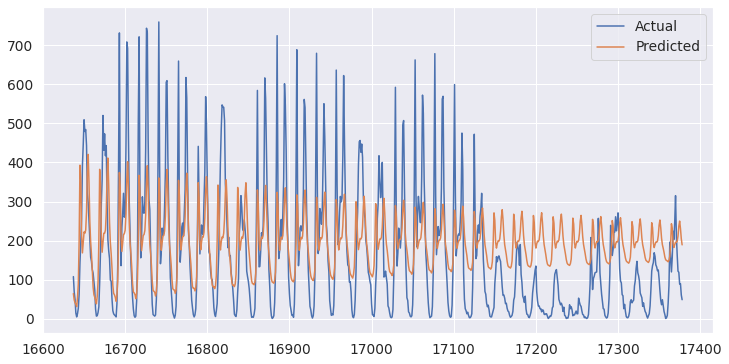

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# Train an ARIMA model
model = ARIMA(train['total_count'], order=(5,1,5), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Plot the predicted values against the actual values
plt.figure(figsize=(12,6))
plt.plot(test['total_count'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# Calculate R2 train score
y_train_pred = model_fit.predict(start=0, end=len(train)-1, typ='levels')
r2_train = r2_score(train['total_count'], y_train_pred)

# Calculate R2 test score
r2_test = r2_score(test['total_count'], predictions)

# Calculate adjusted R2 train score
adj_r2_train = 1 - (1 - r2_train) * (len(train) - 1) / (len(train) - train.shape[1] - 1)

# Calculate adjusted R2 test score
adj_r2_test = 1 - (1 - r2_test) * (len(test) - 1) / (len(test) - train.shape[1] - 1)

# Calculate MAE train score
mae_train = mean_absolute_error(train['total_count'], y_train_pred)

# Calculate MAE test score
mae_test = mean_absolute_error(test['total_count'], predictions)

# Print the metrics
print(f"R2 Train Score: {r2_train:.4f}")
print(f"R2 Test Score: {r2_test:.4f}")
print(f"Adjusted R2 Train Score: {adj_r2_train:.4f}")
print(f"Adjusted R2 Test Score: {adj_r2_test:.4f}")
print(f"MAE Train Score: {mae_train:.4f}")
print(f"MAE Test Score: {mae_test:.4f}")


R2 Train Score: 0.8692
R2 Test Score: 0.3629
Adjusted R2 Train Score: 0.8690
Adjusted R2 Test Score: 0.3407
MAE Train Score: 42.8891
MAE Test Score: 105.6195


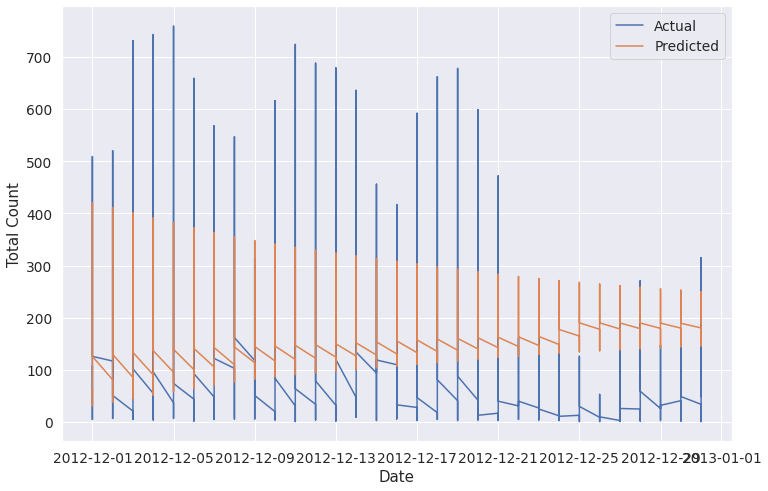

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(test['datetime'], test['total_count'], label='Actual')
plt.plot(test['datetime'], predictions, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Count')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(test['total_count'], predictions))

print(f"RMSE: {rmse}")

RMSE: 131.52761050065257


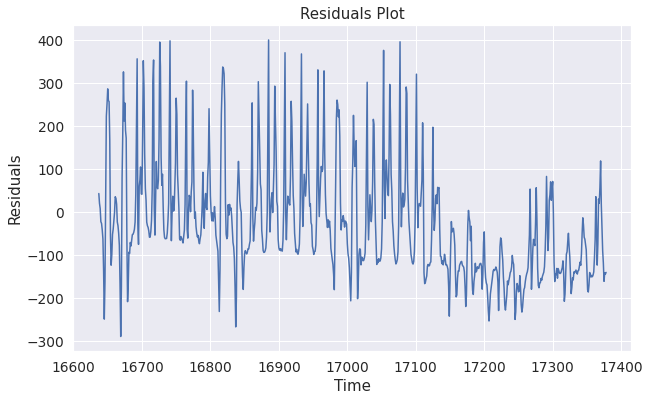

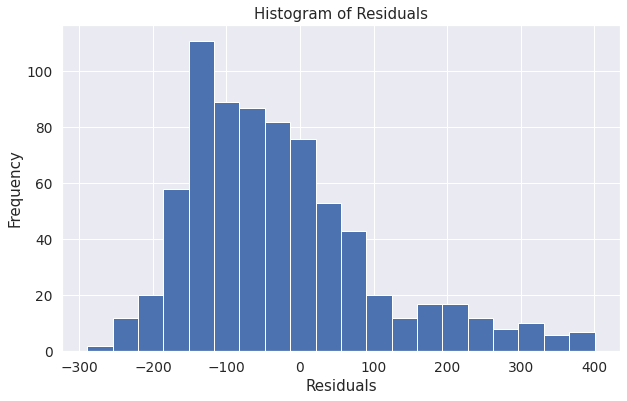

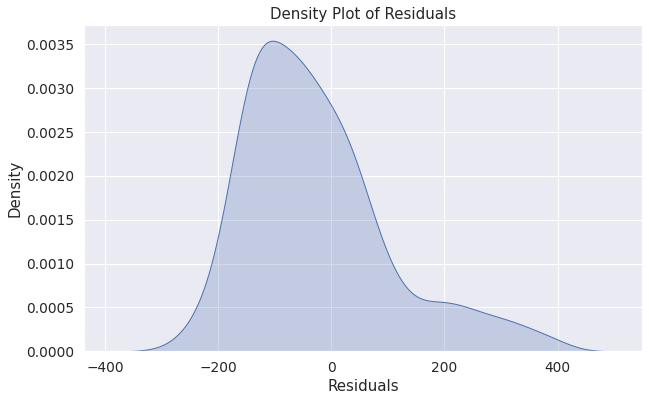

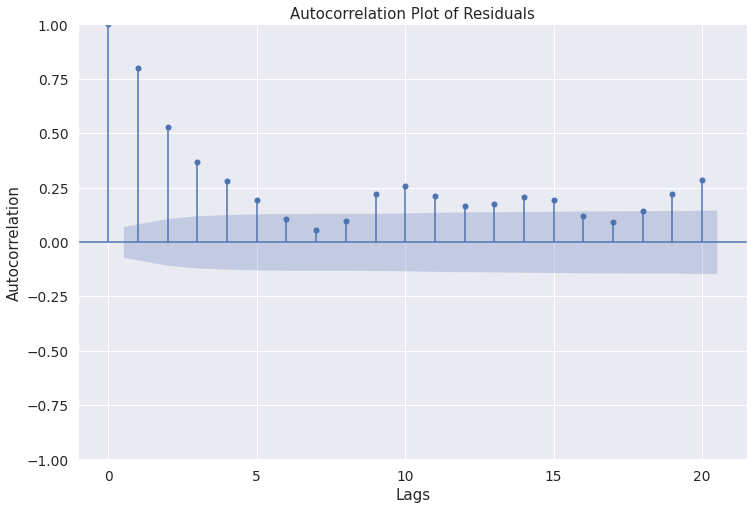

In [ ]:
# Calculate residuals
residuals = test['total_count'] - predictions

# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot density plot of residuals
plt.figure(figsize=(10,6))
sns.kdeplot(residuals, shade=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Plot autocorrelation plot of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation Plot of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


PACF plot has a significant spike not only at lag 1, so not all the higher-order autocorrelations are effectively explained by the lag-1 autocorrelation, but lag-5 or 6.



/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation of Residuals')

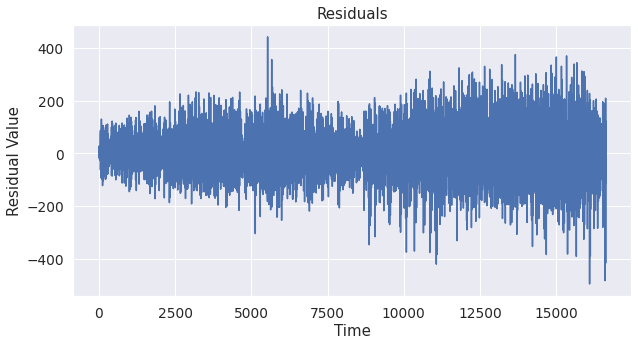

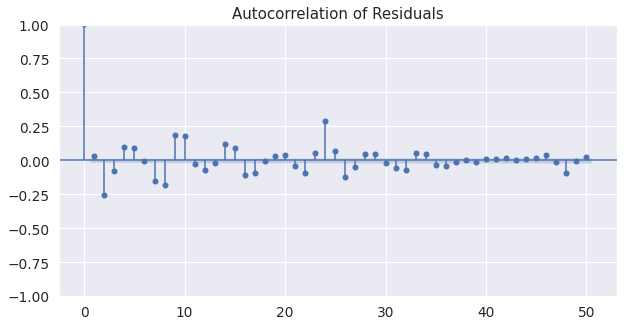

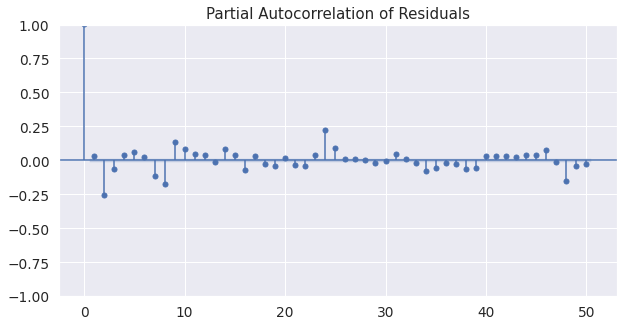

In [ ]:
# Import necessary libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Generate residuals from the ARIMA model
residuals = model_fit.resid

# Plot the residuals
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(residuals)
ax.set_title('Residuals')
ax.set_xlabel('Time')
ax.set_ylabel('Residual Value')

# Plot the ACF and PACF of the residuals
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(residuals, lags=50, ax=ax)
ax.set_title('Autocorrelation of Residuals')

fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(residuals, lags=50, ax=ax)
ax.set_title('Partial Autocorrelation of Residuals')



In the first plot, we can visually inspect whether the residuals have a constant mean and variance over time. In the ACF and PACF plots, we look for any significant correlations that suggest that the residuals have a pattern that is not accounted for by the model. Finally, the Ljung-Box test checks whether there is any remaining autocorrelation in the residuals.

If the p-value of the Ljung-Box test is less than 0.05 for any lag, it suggests that the residuals are not white noise. If the p-value is greater than 0.05 for all lags, we can conclude that the residuals are white noise.


In [ ]:

# Check for white noise using the Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(residuals)
print("Durbin-Watson test statistic:", dw_test)

# If the Durbin-Watson test statistic is close to 2, then there is no autocorrelation in the residuals and they are white noise.


Durbin-Watson test statistic: 1.930441380952169


If the Durbin-Watson test statistic is close to 2, then there is no autocorrelation in the residuals and they are white noise.

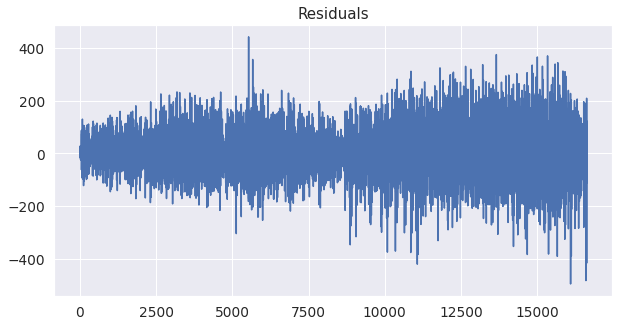

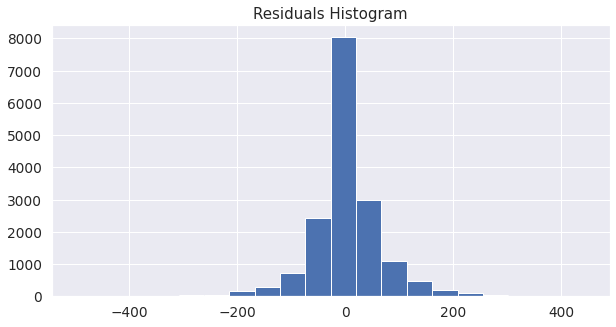

Ljung-Box test p-value: lb_pvalue
Shapiro-Wilk test p-value: 0.0


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Get the residuals
residuals = model_fit.resid

# Plot the residuals
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot a histogram of the residuals
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=20)
plt.title('Residuals Histogram')
plt.show()

# Perform a Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(residuals, lags=10)
print('Ljung-Box test p-value:', pvalue)

# Perform a normality test
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print('Shapiro-Wilk test p-value:', p)


Shapiro-Wilk Test is greater than 0.05, the data is normal. If it is below 0.05, the data significantly deviate from a normal distribution. So in this case I have not have normal distribution.

# 6. Comparison with previous homework results

I am comparing previuous homework models to current models. 
NOTE: In my previous homework I made a mistake, so submitted wrong results. I calculated the right results, but only in a separated notebook. I DID NOT modify submitted homework!

## KNN Regressor 

R2 Train Score: 0.26995283067565445

R2 Test Score: -0.11102481834556688

R2 adjusted Train Score: 0.25711683648973194

R2 adjusted Test Score: -0.1935777460244945

MAE Train: 32.01899280575539

MAE Test: 42.12011494252874

# Decision Tree Regressor 

R2 Train Score: 1.0

R2 Test Score: -0.6664862977352637

R2 adjusted Train Score: 1.0

R2 adjusted Test Score: -0.7903119049973266

MAE Train: 0.0

MAE Test: 49.91379310344828

# Random Forest 

R2 Train Score: 0.19243402491715655

R2 Test Score: 0.04397008692945881

R2 adjusted Train Score: 0.1782350627178978

R2 adjusted Test Score: -0.027066191441107668

MAE Train: 33.59425241842599

MAE Test: 38.54173341261985

# SVM Regressor 

R2 Train Score: -0.0017130757975745148

R2 Test Score: -0.054670455890448943

R2 adjusted Train Score: -0.019325613394015395

R2 adjusted Test Score: -0.1330360625200797

MAE Train: 35.42338595562133

MAE Test: 38.431657896392835

# XGBoost

R2 Train Score: 0.25630723728962357

R2 Test Score: 0.01546890835404835

R2 adjusted Train Score: 0.24323132058262797

R2 adjusted Test Score: -0.05768510464750842

MAE Train: 31.232741378537185

MAE Test: 38.40487485096372

#THIS WEEK MODELS

# Linear regression model (endogenous variables)

R2 Train Score: 0.4444278424628141

R2 Test Score: 0.062181427497167374

R2 adjusted Train Score: 0.44402680385053994

R2 adjusted Test Score: 0.0467440847399192

MAE Train: 100.92337885209052

MAE Test: 132.57559853084604

# Linear regression model (endo + exo variables)

R2 Train Score: 0.536593722378174

R2 Test Score: 0.4146329302447732

R2 adjusted Train Score: 0.5361755108286688

R2 adjusted Test Score: 0.4025385692994172

MAE Train: 93.14222460923547

MAE Test: 96.01162650479988

# ARIMA (1, 0, 1)

R2 Train Score: 0.7680

R2 Test Score: -0.0180

Adjusted R2 Train Score: 0.7677

Adjusted R2 Test Score: -0.0535

MAE Train Score: 58.3522

MAE Test Score: 135.9015

# ARIMA (5,1,5)

R2 Train Score: 0.8063

R2 Test Score: -0.0212

Adjusted R2 Train Score: 0.8060

Adjusted R2 Test Score: -0.0568

MAE Train Score: 54.3827

MAE Test Score: 139.3607

# ARIMA (5,1,5) + seasonal

R2 Train Score: 0.8692

R2 Test Score: 0.3629

Adjusted R2 Train Score: 0.8690

Adjusted R2 Test Score: 0.3407

MAE Train Score: 42.8891

MAE Test Score: 105.6195

We can see that last week models have better performance, but those models contains several variables. 

# 7. Prophet

In [ ]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 321.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.2 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

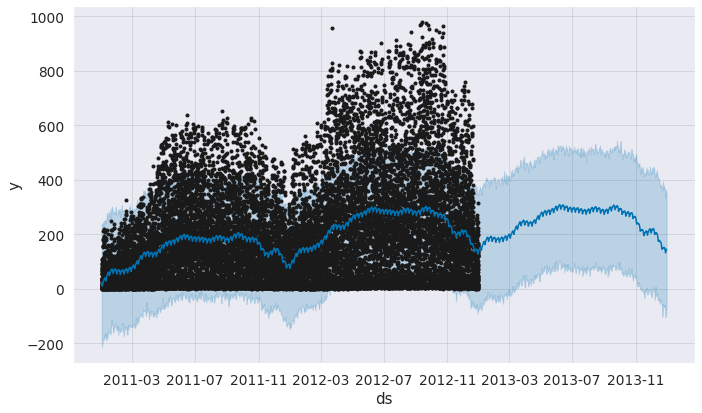

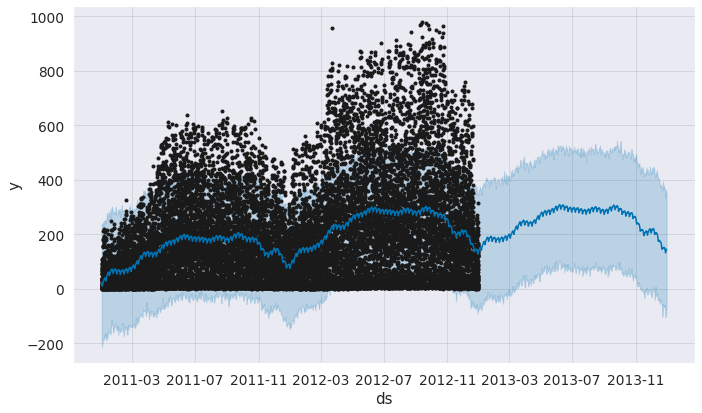

In [ ]:
# Rename columns for Prophet
data = data.rename(columns={'datetime': 'ds', 'total_count': 'y'})

# Create a new Prophet model
model = Prophet(daily_seasonality=True)

# Fit the model to the data
model.fit(data)

# Make predictions for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict the values for the future dates
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)



# 8. SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = data.rename(columns={'ds': 'datetime', 'y': 'total_count'})

# Convert the datetime column to a pandas datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Split data into train and test sets
train = data[data['datetime'] < '2012-12-01']
test = data[data['datetime'] >= '2012-12-01']

# Train a SARIMAX model
model = SARIMAX(train['total_count'], order=(5, 1, 5), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Print the predictions
print(predictions)


                                      SARIMAX Results                                       
Dep. Variable:                          total_count   No. Observations:                16637
Model:             SARIMAX(5, 1, 5)x(1, 0, [1], 24)   Log Likelihood              -93753.587
Date:                              Tue, 14 Mar 2023   AIC                         187533.174
Time:                                      15:30:46   BIC                         187633.525
Sample:                                           0   HQIC                        187566.301
                                            - 16637                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4767      0.034     14.073      0.000       0.410       0.543
ar.L2         -0.23

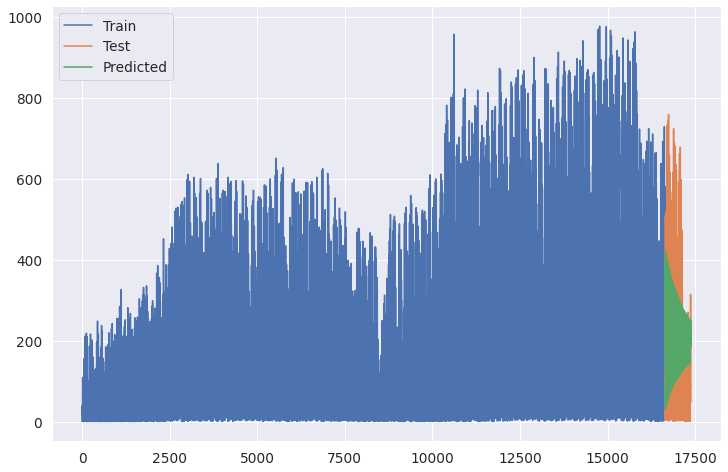

In [ ]:
# Plot the actual values and predicted values
plt.plot(train['total_count'], label='Train')
plt.plot(test['total_count'], label='Test')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.show()